In [3]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import time
from datetime import datetime
import itertools
import gc
import pickle
from xgboost import XGBRegressor
from xgboost import plot_importance

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [4]:
# 데이터 불러오기
#path = '/content/drive/MyDrive/data/'
path = './data/'
sales = pd.read_csv(path + 'sales_train.csv')
items = pd.read_csv(path + 'items.csv')
item_categories = pd.read_csv(path + 'item_categories.csv')
shops = pd.read_csv(path + 'shops.csv')
test = pd.read_csv(path + 'test.csv')

In [5]:
len(items), len(shops)

(22170, 60)

In [ ]:
# 데이터 불러오기

sales = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')

# 1. Preprocessing

## 1) sales data 

In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
sales.info()   # 데이터 기본 정보 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [6]:
sales.shape   # sales 형태 확인

(2935849, 6)

In [7]:
sales.corr()   # 상관계수

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date_block_num,1.000000,0.019273,0.009356,0.095010,0.009402
shop_id,0.019273,1.000000,0.029396,-0.024034,-0.005230
item_id,0.009356,0.029396,1.000000,-0.134104,0.016650
item_price,0.095010,-0.024034,-0.134104,1.000000,0.011197
item_cnt_day,0.009402,-0.005230,0.016650,0.011197,1.000000


In [8]:
sales.describe()   # 데이터 요약통계량 확인

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


### 날짜형식 변환

In [9]:
sales.date = pd.to_datetime(sales.date,format = '%d.%m.%Y',errors = 'raise')
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


### 중복데이터 처리

In [10]:
sales.duplicated().sum()  # sales데이터 중복행 6개

6

In [11]:
# 나머지 데이터프레임 중복값 확인
print(test.duplicated().sum())
print(items.duplicated().sum())
print(item_categories.duplicated().sum())
print(shops.duplicated().sum())

0
0
0
0


In [12]:
# sales 중복데이터 6개 삭제
sales = sales.drop_duplicates()
sales.shape  # (2935849, 6) -> (2935843, 6)

(2935843, 6)

### 결측치 처리

In [13]:
# 결측치 없음
sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

### 이상치 처리
- boxplot 활용해 이상치 확인

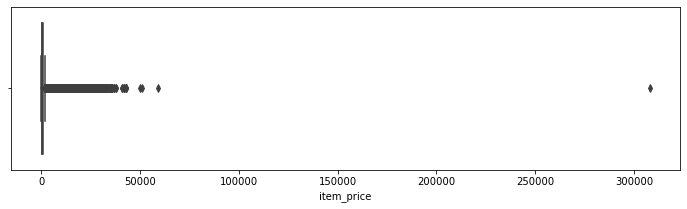

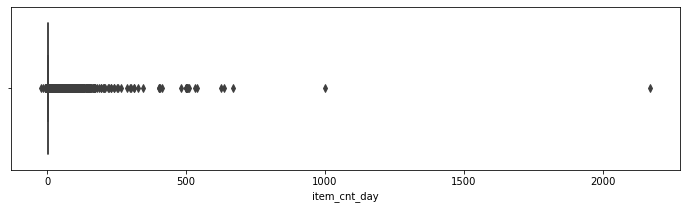

In [14]:
plt.figure(figsize=(12,3))
sns.boxplot(x='item_price', data=sales)

plt.figure(figsize=(12,3))
sns.boxplot(x='item_cnt_day', data=sales)
plt.show()

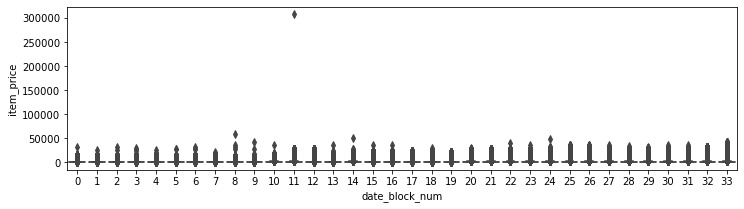

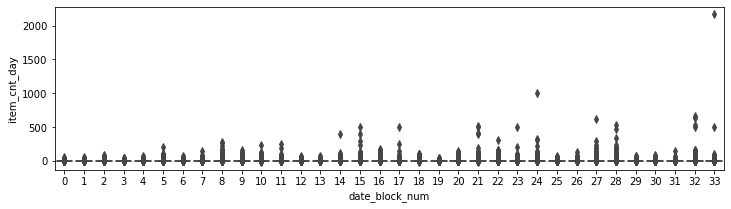

In [15]:
plt.figure(figsize=(12,3))
sns.boxplot(x = 'date_block_num', y = 'item_price', data = sales)

plt.figure(figsize=(12,3))
sns.boxplot(x = 'date_block_num', y = 'item_cnt_day', data = sales)
plt.show()

In [16]:
# 이상치 확인
#한 아이템이 500개 초과 팔렸을때
sales[sales.item_cnt_day > 500]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1573253,2014-04-22,15,27,8057,1200.000000,502.0
1708207,2014-06-28,17,25,20949,5.000000,501.0
2048518,2014-10-02,21,12,9242,1500.000000,512.0
2067669,2014-10-09,21,55,19437,899.000000,508.0
2326930,2015-01-15,24,12,20949,4.000000,1000.0
2608040,2015-04-14,27,12,3731,1904.548077,624.0
2626181,2015-05-19,28,12,11373,155.192950,539.0
2851073,2015-09-29,32,55,9249,1500.000000,533.0
2851091,2015-09-30,32,55,9249,1702.825746,637.0
2864235,2015-09-30,32,12,9248,1692.526158,669.0


In [17]:
sales[sales.item_cnt_day >= 500].count()

date              14
date_block_num    14
shop_id           14
item_id           14
item_price        14
item_cnt_day      14
dtype: int64

In [18]:
sales[sales.item_price >= 50000].count()

date              3
date_block_num    3
shop_id           3
item_id           3
item_price        3
item_cnt_day      3
dtype: int64

In [19]:
# 뚜렷한 이상치를 우선 제거 
sales = sales[sales.item_cnt_day < 500]
sales = sales[sales.item_price < 50000]

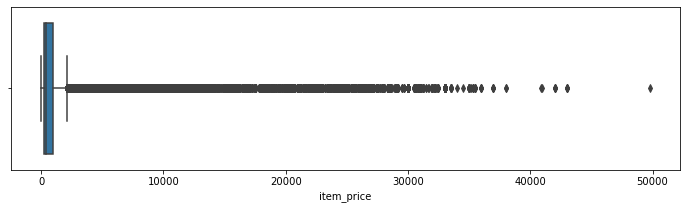

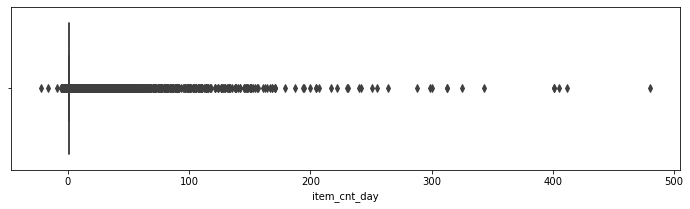

In [20]:
# boxplot으로 이상치 재확인
plt.figure(figsize=(12,3))
sns.boxplot(x='item_price', data=sales);
plt.figure(figsize=(12,3))
sns.boxplot(x='item_cnt_day', data=sales)

plt.show()

### 음수값 처리
- item_price 컬럼과 item_cnt_day 컬럼의 음수값 처리하기

In [21]:
# item_price 가 0 이하인 경우
(sales.item_price <= 0).sum()

1

In [22]:
sales = sales[sales.item_price > 0] # 음수 값 처리

In [23]:
# item_cnt_day 가 0 미만인 경우
(sales['item_cnt_day'] < 0).sum()

7356

- 판매된 제품의 개수가 음수(-) 인 경우 -> 환불된 제품의 개수로 추정
- 이전의 판매된 내역과 함께 제거하기! -> 환불모듈 적용

In [24]:
# 환불모듈 적용
k = sales[sales.item_cnt_day < 0]
timefunc = time.time()

for i in range(len(k)):
    try:
        a = (sales[(sales.item_id == k.iloc[i,3]) & (sales.shop_id == k.iloc[i,2])])
        if a.date.min() < k.iloc[i,0]:
            h = a[(a.date==a.date[a.date < k.iloc[i,0]].max())].index[0]
            if sales.loc[h,'item_cnt_day'] > abs(k.iloc[i,5]):
                sales.loc[h,'item_cnt_day'] += k.iloc[i,5]
        else:
            pass
    except:
        pass
    
sales.drop(sales[sales.item_cnt_day < 0].index, axis = 0,inplace = True)

print(time.time() - timefunc)
sales.head(), sales.shape

71.76606798171997


(        date  date_block_num  shop_id  item_id  item_price  item_cnt_day
 0 2013-01-02               0       59    22154      999.00           1.0
 1 2013-01-03               0       25     2552      899.00           1.0
 3 2013-01-06               0       25     2554     1709.05           1.0
 4 2013-01-15               0       25     2555     1099.00           1.0
 5 2013-01-10               0       25     2564      349.00           1.0,
 (2928469, 6))

## 2) items data 
- item_id와 item_category_id가 숫자로 매핑되어있어 item_name 컬럼만 drop

In [25]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [26]:
# item_name 컬럼 drop 
items.drop(['item_name'], axis=1, inplace=True)
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


## 3) item_categories data
- item_category_name을 라벨인코딩하여 type_id, sub_id 컬럼 생성
  - type_id: maincategory의 라벨인코딩 값
  - sub_id: subcategory의 라벨인코딩 값

In [27]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [28]:
type_encoder = LabelEncoder()

item_categories['split_name'] = item_categories['item_category_name'].str.split(' - ')
item_categories['type'] = item_categories['split_name'].map(lambda x: x[0].strip())
item_categories['type_id'] = type_encoder.fit_transform(item_categories['type'])

In [29]:
subtype_encoder = LabelEncoder()

item_categories['sub'] = item_categories['split_name'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['sub_id'] = subtype_encoder.fit_transform(item_categories['sub'])

In [30]:
item_categories.head()

,item_category_name,item_category_id,split_name,type,type_id,sub,sub_id
0,PC - Гарнитуры/Наушники,0,"[PC, Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники,31
1,Аксессуары - PS2,1,"[Аксессуары, PS2]",Аксессуары,1,PS2,11
2,Аксессуары - PS3,2,"[Аксессуары, PS3]",Аксессуары,1,PS3,12
3,Аксессуары - PS4,3,"[Аксессуары, PS4]",Аксессуары,1,PS4,13
4,Аксессуары - PSP,4,"[Аксессуары, PSP]",Аксессуары,1,PSP,15


In [31]:
item_categories['type'].value_counts()
# type으로 이상할만한 이름은 없다.

Книги                                13
Подарки                              12
Игры                                  8
Игровые консоли                       8
Аксессуары                            7
Музыка                                6
Программы                             6
Кино                                  5
Игры PC                               4
Карты оплаты                          4
Служебные                             2
Элементы питания                      1
Чистые носители (шпиль)               1
Доставка товара                       1
Игры MAC                              1
Чистые носители (штучные)             1
Карты оплаты (Кино, Музыка, Игры)     1
Билеты (Цифра)                        1
PC                                    1
Игры Android                          1
Name: type, dtype: int64

In [32]:
item_categories = item_categories[['item_category_id','type_id','sub_id']]
item_categories.head()

,item_category_id,type_id,sub_id
0,0,0,31
1,1,1,11
2,2,1,12
3,3,1,13
4,4,1,15


## 4) shops data
- shop_name컬럼의 지역명을 라벨인코딩하여 city_id 컬럼 생성

In [33]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [34]:
# shop name 확인
shops['shop_name'].value_counts()

Тюмень ТЦ "Гудвин"                                 1
Н.Новгород ТРЦ "РИО"                               1
СПб ТК "Сенная"                                    1
Ярославль ТЦ "Альтаир"                             1
Балашиха ТРК "Октябрь-Киномир"                     1
Красноярск ТЦ "Июнь"                               1
Сергиев Посад ТЦ "7Я"                              1
Москва ТЦ "Ареал" (Беляево)                        1
Волжский ТЦ "Волга Молл"                           1
РостовНаДону ТРК "Мегацентр Горизонт"              1
Москва ТЦ "Перловский"                             1
Тюмень ТЦ "Зеленый Берег"                          1
Жуковский ул. Чкалова 39м?                         1
Воронеж ТРЦ Сити-Парк "Град"                       1
Адыгея ТЦ "Мега"                                   1
Воронеж (Плехановская, 13)                         1
Москва ТЦ "Серебряный Дом"                         1
РостовНаДону ТРК "Мегацентр Горизонт" Островной    1
Н.Новгород ТРЦ "Фантастика"                   

In [35]:
# 도시명을 공백(' ')을 기준으로 분리하기 위해 수정
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

In [36]:
# 공백(' ')을 기준으로 분리
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [37]:
# '!' 문자가 포함된 지명과 포함되지 않은 지명이 중복으로 표기됨. -> 통일시킴
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

In [38]:
shops['city'].value_counts()
# Интернет-магазин :온라인 상점?
# Выездная : 지명인지 모르겠음, 어디에도 지명이라고 안나옴
# 그래도 다른 city와 분리하기 위해 city_id로 만들어 두기로 함.

Москва              13
Якутск               4
Воронеж              3
РостовНаДону         3
Тюмень               3
Уфа                  2
Красноярск           2
Новосибирск          2
СПб                  2
Самара               2
Казань               2
Н.Новгород           2
Жуковский            2
Вологда              1
Химки                1
Интернет-магазин     1
Волжский             1
Чехов                1
Цифровой             1
Сургут               1
Калуга               1
СергиевПосад         1
Ярославль            1
Омск                 1
Адыгея               1
Курск                1
Выездная             1
Томск                1
Балашиха             1
Мытищи               1
Коломна              1
Name: city, dtype: int64

In [39]:
city_encoder = LabelEncoder()

shops['city_id'] = city_encoder.fit_transform(shops['city'])
shops = shops[['shop_id', 'city_id']]
shops.head()

,shop_id,city_id
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [40]:
shops.city_id.value_counts()

13    13
29     4
18     3
4      3
24     3
19     2
20     2
16     2
11     2
15     2
8      2
6      2
25     2
26     1
23     1
22     1
21     1
27     1
28     1
0      1
17     1
1      1
14     1
12     1
10     1
9      1
7      1
5      1
3      1
2      1
30     1
Name: city_id, dtype: int64

## 5) test data
- 예측달 34의 값이 채워진 date_block_num 컬럼 생성

In [41]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [42]:
test.shape

(214200, 3)

In [43]:
len(test.shop_id.unique())
len(set(test.item_id) - set(sales.item_id))

363

- test 데이터에서 shop_id는 42개  
test 데이터에는 있지만 sales 데이터에는 없는 item_id가 총 363개
- 363개의 item_id에 대한 판매량은 0으로 예측

In [44]:
# date_block_num 컬럼 생성
test['date_block_num'] = 34

In [45]:
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


## 6) submission data

In [46]:
submission = pd.read_csv(path+'sample_submission.csv')
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


## 7) 데이터프레임 merge 

### revenue (일 매출액) 컬럼 생성

In [47]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0


In [48]:
# 총 수익
sales['revenue'] = sales['item_price'] * sales['item_cnt_day']
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,2013-01-02,0,59,22154,999.00,1.0,999.00
1,2013-01-03,0,25,2552,899.00,1.0,899.00
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00
5,2013-01-10,0,25,2564,349.00,1.0,349.00


### matrix 데이터프레임 생성 및 컬럼추가
- 월별(date_block_num), 상점별(shop_id), 아이템별(item_id)의 matrix 데이터프레임 생성
- test 데이터와 matrix 데이터 결합

In [49]:
ts = time.time() # 코드 시작 시간
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id'] # 월별, 상점별, 아이템별

for i in range(34):
    sales_df = sales[sales.date_block_num == i]
    matrix.append(np.array(list(itertools.product([i], 
                    sales_df.shop_id.unique(), sales_df.item_id.unique())),
                    dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)

# int8 -> Byte (-128 to 127), int16 -> Integer (-32768 to 32767)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)

matrix.sort_values(cols, inplace=True)
time.time()-ts # 코드 실행 시간

# itertools.product : 중복 순열
# 월별, 상점별, 아이템별로 모든 가능한 조합을 나타낸다.
# vstack : 이 조합들을 월 순서대로 행 아래에 더해준다.

10.89820909500122

In [50]:
matrix.head()

,date_block_num,shop_id,item_id
139168,0,0,19
141406,0,0,27
144881,0,0,28
142572,0,0,29
138861,0,0,32


- test데이터와 matrix데이터 결합

In [51]:
matrix = pd.concat([matrix, test], ignore_index = True, sort=False, keys=cols)
matrix.fillna(0, inplace = True)
matrix

,date_block_num,shop_id,item_id,ID
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,0.0
...,...,...,...,...
11098655,34,45,18454,214195.0
11098656,34,45,16188,214196.0
11098657,34,45,15757,214197.0
11098658,34,45,19648,214198.0


In [52]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11098660 entries, 0 to 11098659
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int64  
 1   shop_id         int64  
 2   item_id         int64  
 3   ID              float64
dtypes: float64(1), int64(3)
memory usage: 338.7 MB


In [53]:
matrix['ID'] = matrix['ID'].astype(np.int32)

In [54]:
matrix.head()

,date_block_num,shop_id,item_id,ID
0,0,0,19,0
1,0,0,27,0
2,0,0,28,0
3,0,0,29,0
4,0,0,32,0


In [55]:
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


- city_id, item_category_id, type_id, sub_id 컬럼추가 (merge)

In [56]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')  # ciry_id 추가
matrix= pd.merge(matrix, items, on=['item_id'], how='left')   # item_category 추가
matrix= pd.merge(matrix, item_categories, on=['item_category_id'], how='left') # type_id, sub_id 추가

matrix['city_id'] = matrix['city_id'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_id'] = matrix['type_id'].astype(np.int8)
matrix['sub_id'] = matrix['sub_id'].astype(np.int8)

In [57]:
matrix.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id
0,0,0,19,0,29,40,11,6
1,0,0,27,0,29,19,5,12
2,0,0,28,0,29,30,8,57
3,0,0,29,0,29,23,5,18
4,0,0,32,0,29,40,11,6


In [58]:
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)

In [59]:
matrix

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id
0,0,0,19,0,29,40,11,6
1,0,0,27,0,29,19,5,12
2,0,0,28,0,29,30,8,57
3,0,0,29,0,29,23,5,18
4,0,0,32,0,29,40,11,6
...,...,...,...,...,...,...,...,...
11098655,34,45,18454,214195,20,55,13,4
11098656,34,45,16188,214196,20,64,14,44
11098657,34,45,15757,214197,20,55,13,4
11098658,34,45,19648,214198,20,40,11,6


- 월별 판매갯수(item_cnt_month)데이터 생성 및 matrix 데이터프레임에 merge
  - 월별, 상점별, 아이템별을 그룹화 하고, 일별 판매 개수('item_cnt_day') 합을 구함

In [60]:
group = sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
group.head()

item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              0       32               6.0
                       33               3.0
                       35               1.0
                       43               1.0
                       51               2.0

In [61]:
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [62]:
# matrix 에 gorup데이터 merge 하여 컬럼을 붙임('item_cnt_month')
matrix = pd.merge(matrix, group, how='left')
matrix.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month
0,0,0,19,0,29,40,11,6,NaN
1,0,0,27,0,29,19,5,12,NaN
2,0,0,28,0,29,30,8,57,NaN
3,0,0,29,0,29,23,5,18,NaN
4,0,0,32,0,29,40,11,6,6.0


- NaN 값은 판매 개수가 없다고 판단 -> 0으로 처리 및 임계값을 정해주기 위해 clip 사용

In [63]:
print(matrix.item_cnt_month.max())
print(matrix.item_cnt_month.mean())
print(matrix.item_cnt_month.median())
print(len(matrix.item_cnt_month))

print((matrix.item_cnt_month > 30).sum())

# 30이 넘어가는 값은 6168개

1305.0
2.2667002855950766
1.0
11098660
6168


<AxesSubplot:xlabel='date_block_num', ylabel='item_cnt_month'>

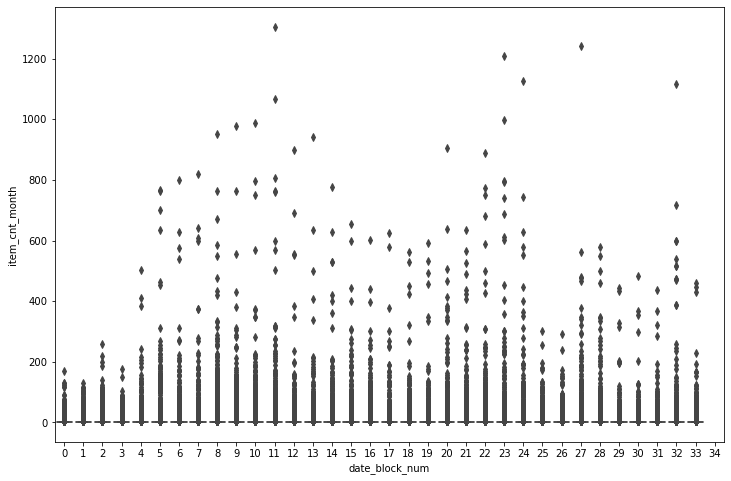

In [64]:
plt.figure(figsize=(12,8))
sns.boxplot(x = 'date_block_num', y = 'item_cnt_month', data = matrix)

In [65]:
# NaN 값은 판매 개수가 없다고 판단 -> 0으로 처리 및 임계값을 정해주기 위해 clip 사용
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0,30).astype(np.float16))
matrix.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month
0,0,0,19,0,29,40,11,6,0.0
1,0,0,27,0,29,19,5,12,0.0
2,0,0,28,0,29,30,8,57,0.0
3,0,0,29,0,29,23,5,18,0.0
4,0,0,32,0,29,40,11,6,6.0


- shop_cnt_month (shop별 월 총 판매수량) 데이터 생성 및 matrix 데이터프레임에 merge

In [66]:
group2 = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['sum']})
group2.columns = ['shop_cnt_month']
group2.reset_index(inplace=True)

In [67]:
group2.head()

,date_block_num,shop_id,shop_cnt_month
0,0,0,5544.0
1,0,1,2942.0
2,0,2,1149.0
3,0,3,767.0
4,0,4,2114.0


In [68]:
matrix = pd.merge(matrix, group2, on=['date_block_num', 'shop_id'], how='left')
matrix.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month
0,0,0,19,0,29,40,11,6,0.0,5544.0
1,0,0,27,0,29,19,5,12,0.0,5544.0
2,0,0,28,0,29,30,8,57,0.0,5544.0
3,0,0,29,0,29,23,5,18,0.0,5544.0
4,0,0,32,0,29,40,11,6,6.0,5544.0


In [69]:
# matrix 원본 카피
matrix1 = matrix.copy()
matrix1.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month
0,0,0,19,0,29,40,11,6,0.0,5544.0
1,0,0,27,0,29,19,5,12,0.0,5544.0
2,0,0,28,0,29,30,8,57,0.0,5544.0
3,0,0,29,0,29,23,5,18,0.0,5544.0
4,0,0,32,0,29,40,11,6,6.0,5544.0


- categoty_cnt_month (categoty별 월 판매수량) 데이터 생성 및 matrix 데이터프레임에 merge

In [70]:
group2 = matrix1.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['sum']})
group2.columns = ['category_cnt_month']
group2.reset_index(inplace=True)
matrix1 = pd.merge(matrix1, group2, on=['date_block_num', 'item_category_id'], how='left')
matrix1.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month
0,0,0,19,0,29,40,11,6,0.0,5544.0,32480.0
1,0,0,27,0,29,19,5,12,0.0,5544.0,8992.0
2,0,0,28,0,29,30,8,57,0.0,5544.0,21776.0
3,0,0,29,0,29,23,5,18,0.0,5544.0,4172.0
4,0,0,32,0,29,40,11,6,6.0,5544.0,32480.0


- city_cnt_month (city별 월 판매수량) 데이터 생성 및 matrix 데이터프레임에 merge

In [71]:
group_1 = matrix1.groupby(['date_block_num', 'city_id']).agg({'item_cnt_month': ['sum']})
group_1.columns = ['city_cnt_month']
group_1.reset_index(inplace=True)
matrix1 = pd.merge(matrix1, group_1, on=['date_block_num', 'city_id'], how='left')
matrix1.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month,city_cnt_month
0,0,0,19,0,29,40,11,6,0.0,5544.0,32480.0,8488.0
1,0,0,27,0,29,19,5,12,0.0,5544.0,8992.0,8488.0
2,0,0,28,0,29,30,8,57,0.0,5544.0,21776.0,8488.0
3,0,0,29,0,29,23,5,18,0.0,5544.0,4172.0,8488.0
4,0,0,32,0,29,40,11,6,6.0,5544.0,32480.0,8488.0


- sub_cnt_month (subcategory별 월 판매수량) 데이터 생성 및 matrix 데이터프레임에 merge

In [72]:
types = matrix1.groupby(['date_block_num', 'sub_id']).agg({'item_cnt_month' : 'sum'})
types.columns = ['sub_cnt_month']
types.reset_index(inplace=True)
matrix1 = pd.merge(matrix1, types, on = ['date_block_num', 'sub_id'], how = 'left')
matrix1.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month,city_cnt_month,sub_cnt_month
0,0,0,19,0,29,40,11,6,0.0,5544.0,32480.0,8488.0,32480.0
1,0,0,27,0,29,19,5,12,0.0,5544.0,8992.0,8488.0,10768.0
2,0,0,28,0,29,30,8,57,0.0,5544.0,21776.0,8488.0,21776.0
3,0,0,29,0,29,23,5,18,0.0,5544.0,4172.0,8488.0,5320.0
4,0,0,32,0,29,40,11,6,6.0,5544.0,32480.0,8488.0,32480.0


- item_shop_price(shop별,item별 평균 가격) 데이터 생성 및 matrix 데이터프레임에 merge

In [73]:
group_2 = sales.groupby(['shop_id', 'item_id']).agg({'item_price': ['mean']})
group_2.columns = ['item_shop_price'] # item_price_by_shop
group_2.reset_index(inplace=True)
matrix1 = pd.merge(matrix1, group_2, on = ['shop_id', 'item_id'], how = 'left')
matrix1.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month,city_cnt_month,sub_cnt_month,item_shop_price
0,0,0,19,0,29,40,11,6,0.0,5544.0,32480.0,8488.0,32480.0,NaN
1,0,0,27,0,29,19,5,12,0.0,5544.0,8992.0,8488.0,10768.0,NaN
2,0,0,28,0,29,30,8,57,0.0,5544.0,21776.0,8488.0,21776.0,NaN
3,0,0,29,0,29,23,5,18,0.0,5544.0,4172.0,8488.0,5320.0,NaN
4,0,0,32,0,29,40,11,6,6.0,5544.0,32480.0,8488.0,32480.0,221.0


- item_shop_cnt_month(shop,item별 판매량) 데이터 생성 및 matrix 데이터프레임에 merge

In [74]:
item_shop = matrix1.groupby(['date_block_num', 'shop_id','item_id']).agg({'item_cnt_month' : 'sum'})
item_shop.columns = ['item_shop_cnt_month']
item_shop.reset_index(inplace=True)
matrix1 = pd.merge(matrix1, item_shop, on = ['date_block_num', 'shop_id','item_id'], how = 'left')
matrix1.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month,city_cnt_month,sub_cnt_month,item_shop_price,item_shop_cnt_month
0,0,0,19,0,29,40,11,6,0.0,5544.0,32480.0,8488.0,32480.0,NaN,0.0
1,0,0,27,0,29,19,5,12,0.0,5544.0,8992.0,8488.0,10768.0,NaN,0.0
2,0,0,28,0,29,30,8,57,0.0,5544.0,21776.0,8488.0,21776.0,NaN,0.0
3,0,0,29,0,29,23,5,18,0.0,5544.0,4172.0,8488.0,5320.0,NaN,0.0
4,0,0,32,0,29,40,11,6,6.0,5544.0,32480.0,8488.0,32480.0,221.0,6.0


In [75]:
matrix2 = matrix1.copy()

In [76]:
matrix2['season'] = np.where(matrix2['date_block_num'].isin([2,3,4,14,15,16,26,27,28]), 0,
                            np.where(matrix2['date_block_num'].isin([5,6,7,17,18,19,29,30,31]), 1,
                                    np.where(matrix2['date_block_num'].isin([8,9,10,20,21,22,32,33]), 2,3)))
matrix2.tail()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month,city_cnt_month,sub_cnt_month,item_shop_price,item_shop_cnt_month,season
11098655,34,45,18454,214195,20,55,13,4,0.0,0.0,0.0,0.0,0.0,187.888889,0.0,3
11098656,34,45,16188,214196,20,64,14,44,0.0,0.0,0.0,0.0,0.0,NaN,0.0,3
11098657,34,45,15757,214197,20,55,13,4,0.0,0.0,0.0,0.0,0.0,199.000000,0.0,3
11098658,34,45,19648,214198,20,40,11,6,0.0,0.0,0.0,0.0,0.0,NaN,0.0,3
11098659,34,45,969,214199,20,37,11,1,0.0,0.0,0.0,0.0,0.0,549.000000,0.0,3


- season_avg_item_cnt (계절별 평균 판매 수량)

In [77]:
group = matrix2.groupby(['date_block_num', 'season']).agg({'item_cnt_month': ['mean']})
group.columns = ['season_avg_item_cnt']
group.reset_index(inplace=True)

matrix2 = pd.merge(matrix2, group, on=['date_block_num', 'season'], how='left')
matrix2['season_avg_item_cnt'] = matrix2['season_avg_item_cnt'].astype(np.float16)
matrix2.tail()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month,city_cnt_month,sub_cnt_month,item_shop_price,item_shop_cnt_month,season,season_avg_item_cnt
11098655,34,45,18454,214195,20,55,13,4,0.0,0.0,0.0,0.0,0.0,187.888889,0.0,3,0.0
11098656,34,45,16188,214196,20,64,14,44,0.0,0.0,0.0,0.0,0.0,NaN,0.0,3,0.0
11098657,34,45,15757,214197,20,55,13,4,0.0,0.0,0.0,0.0,0.0,199.000000,0.0,3,0.0
11098658,34,45,19648,214198,20,40,11,6,0.0,0.0,0.0,0.0,0.0,NaN,0.0,3,0.0
11098659,34,45,969,214199,20,37,11,1,0.0,0.0,0.0,0.0,0.0,549.000000,0.0,3,0.0


- season_item_shop_avg_cnt(계절별 item/shop별 평균 판매량)

In [78]:
group = matrix2.groupby(['date_block_num','item_id' ,'shop_id', 'season']).agg({'item_cnt_month': ['mean']})
group.columns = ['season_item_shop_avg_cnt']
group.reset_index(inplace=True)

matrix2 = pd.merge(matrix2, group, on=['date_block_num','item_id' ,'shop_id', 'season'], how='left')
matrix2['season_item_shop_avg_cnt'] = matrix2['season_item_shop_avg_cnt'].astype(np.float16)
matrix2.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month,city_cnt_month,sub_cnt_month,item_shop_price,item_shop_cnt_month,season,season_avg_item_cnt,season_item_shop_avg_cnt
0,0,0,19,0,29,40,11,6,0.0,5544.0,32480.0,8488.0,32480.0,NaN,0.0,3,0.35498,0.0
1,0,0,27,0,29,19,5,12,0.0,5544.0,8992.0,8488.0,10768.0,NaN,0.0,3,0.35498,0.0
2,0,0,28,0,29,30,8,57,0.0,5544.0,21776.0,8488.0,21776.0,NaN,0.0,3,0.35498,0.0
3,0,0,29,0,29,23,5,18,0.0,5544.0,4172.0,8488.0,5320.0,NaN,0.0,3,0.35498,0.0
4,0,0,32,0,29,40,11,6,6.0,5544.0,32480.0,8488.0,32480.0,221.0,6.0,3,0.35498,6.0


- season_shop_avg_cnt (계절별 shop별 평균 판매량)

In [79]:
group = matrix2.groupby(['date_block_num', 'shop_id', 'season']).agg({'item_cnt_month': ['mean']})
group.columns = ['season_shop_avg_cnt']
group.reset_index(inplace=True)

matrix2 = pd.merge(matrix2, group, on=['date_block_num', 'shop_id', 'season'], how='left')
matrix2['season_shop_avg_cnt'] = matrix2['season_shop_avg_cnt'].astype(np.float16)
matrix2.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month,city_cnt_month,sub_cnt_month,item_shop_price,item_shop_cnt_month,season,season_avg_item_cnt,season_item_shop_avg_cnt,season_shop_avg_cnt
0,0,0,19,0,29,40,11,6,0.0,5544.0,32480.0,8488.0,32480.0,NaN,0.0,3,0.35498,0.0,0.683594
1,0,0,27,0,29,19,5,12,0.0,5544.0,8992.0,8488.0,10768.0,NaN,0.0,3,0.35498,0.0,0.683594
2,0,0,28,0,29,30,8,57,0.0,5544.0,21776.0,8488.0,21776.0,NaN,0.0,3,0.35498,0.0,0.683594
3,0,0,29,0,29,23,5,18,0.0,5544.0,4172.0,8488.0,5320.0,NaN,0.0,3,0.35498,0.0,0.683594
4,0,0,32,0,29,40,11,6,6.0,5544.0,32480.0,8488.0,32480.0,221.0,6.0,3,0.35498,6.0,0.683594


- season_city_avg_cnt (계절별 city별 평균 판매량)

In [80]:
group = matrix2.groupby(['date_block_num', 'city_id', 'season']).agg({'item_cnt_month': ['mean']})
group.columns = ['season_city_avg_cnt']
group.reset_index(inplace=True)

matrix2 = pd.merge(matrix2, group, on=['date_block_num', 'city_id', 'season'], how='left')
matrix2['season_city_avg_cnt'] = matrix2['season_city_avg_cnt'].astype(np.float16)
matrix2.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month,city_cnt_month,sub_cnt_month,item_shop_price,item_shop_cnt_month,season,season_avg_item_cnt,season_item_shop_avg_cnt,season_shop_avg_cnt,season_city_avg_cnt
0,0,0,19,0,29,40,11,6,0.0,5544.0,32480.0,8488.0,32480.0,NaN,0.0,3,0.35498,0.0,0.683594,0.523438
1,0,0,27,0,29,19,5,12,0.0,5544.0,8992.0,8488.0,10768.0,NaN,0.0,3,0.35498,0.0,0.683594,0.523438
2,0,0,28,0,29,30,8,57,0.0,5544.0,21776.0,8488.0,21776.0,NaN,0.0,3,0.35498,0.0,0.683594,0.523438
3,0,0,29,0,29,23,5,18,0.0,5544.0,4172.0,8488.0,5320.0,NaN,0.0,3,0.35498,0.0,0.683594,0.523438
4,0,0,32,0,29,40,11,6,6.0,5544.0,32480.0,8488.0,32480.0,221.0,6.0,3,0.35498,6.0,0.683594,0.523438


- season_sub_avg_cnt (계절별 sub-category별 평균 판매량)

In [81]:
group = matrix2.groupby(['date_block_num', 'sub_id', 'season']).agg({'item_cnt_month': ['mean']})
group.columns = ['season_sub_avg_cnt']
group.reset_index(inplace=True)

matrix2 = pd.merge(matrix2, group, on=['date_block_num', 'sub_id', 'season'], how='left')
matrix2['season_sub_avg_cnt'] = matrix2['season_sub_avg_cnt'].astype(np.float16)
matrix2.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,city_cnt_month,sub_cnt_month,item_shop_price,item_shop_cnt_month,season,season_avg_item_cnt,season_item_shop_avg_cnt,season_shop_avg_cnt,season_city_avg_cnt,season_sub_avg_cnt
0,0,0,19,0,29,40,11,6,0.0,5544.0,...,8488.0,32480.0,NaN,0.0,3,0.35498,0.0,0.683594,0.523438,0.301514
1,0,0,27,0,29,19,5,12,0.0,5544.0,...,8488.0,10768.0,NaN,0.0,3,0.35498,0.0,0.683594,0.523438,0.830566
2,0,0,28,0,29,30,8,57,0.0,5544.0,...,8488.0,21776.0,NaN,0.0,3,0.35498,0.0,0.683594,0.523438,1.166016
3,0,0,29,0,29,23,5,18,0.0,5544.0,...,8488.0,5320.0,NaN,0.0,3,0.35498,0.0,0.683594,0.523438,0.582031
4,0,0,32,0,29,40,11,6,6.0,5544.0,...,8488.0,32480.0,221.0,6.0,3,0.35498,6.0,0.683594,0.523438,0.301514


In [82]:
# matrix2 데이터 copy
matrix3 = matrix2.copy()

## 8) Matrix에 new features & lags 추가

In [83]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [84]:
matrix3 = lag_feature(matrix3, [1,3,6,12], 'item_shop_cnt_month')
matrix3

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,season,season_avg_item_cnt,season_item_shop_avg_cnt,season_shop_avg_cnt,season_city_avg_cnt,season_sub_avg_cnt,item_shop_cnt_month_lag_1,item_shop_cnt_month_lag_3,item_shop_cnt_month_lag_6,item_shop_cnt_month_lag_12
0,0,0,19,0,29,40,11,6,0.0,5544.0,...,3,0.35498,0.0,0.683594,0.523438,0.301514,NaN,NaN,NaN,NaN
1,0,0,27,0,29,19,5,12,0.0,5544.0,...,3,0.35498,0.0,0.683594,0.523438,0.830566,NaN,NaN,NaN,NaN
2,0,0,28,0,29,30,8,57,0.0,5544.0,...,3,0.35498,0.0,0.683594,0.523438,1.166016,NaN,NaN,NaN,NaN
3,0,0,29,0,29,23,5,18,0.0,5544.0,...,3,0.35498,0.0,0.683594,0.523438,0.582031,NaN,NaN,NaN,NaN
4,0,0,32,0,29,40,11,6,6.0,5544.0,...,3,0.35498,6.0,0.683594,0.523438,0.301514,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,214195,20,55,13,4,0.0,0.0,...,3,0.00000,0.0,0.000000,0.000000,0.000000,1.0,0.0,0.0,NaN
11098656,34,45,16188,214196,20,64,14,44,0.0,0.0,...,3,0.00000,0.0,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN
11098657,34,45,15757,214197,20,55,13,4,0.0,0.0,...,3,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
11098658,34,45,19648,214198,20,40,11,6,0.0,0.0,...,3,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN


- date_avg_item_cnt(월 평균 판매수량) 컬럼 생성 및 lag[1,3,6,12] -> matrix에 추가

In [85]:
group = matrix3.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)
matrix3 = pd.merge(matrix3, group, on=['date_block_num'], how='left')
matrix3['date_avg_item_cnt'] = matrix3['date_avg_item_cnt'].astype(np.float16)
matrix3 = lag_feature(matrix3, [1,3,6,12], 'date_avg_item_cnt')
matrix3.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,season_sub_avg_cnt,item_shop_cnt_month_lag_1,item_shop_cnt_month_lag_3,item_shop_cnt_month_lag_6,item_shop_cnt_month_lag_12,date_avg_item_cnt,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_6,date_avg_item_cnt_lag_12
0,0,0,19,0,29,40,11,6,0.0,5544.0,...,0.301514,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN
1,0,0,27,0,29,19,5,12,0.0,5544.0,...,0.830566,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN
2,0,0,28,0,29,30,8,57,0.0,5544.0,...,1.166016,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN
3,0,0,29,0,29,23,5,18,0.0,5544.0,...,0.582031,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN
4,0,0,32,0,29,40,11,6,6.0,5544.0,...,0.301514,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN


- date_item_avg_item_cnt(월별 item별 item  평균 판매량) 컬럼 생성

In [86]:
group = matrix3.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)

matrix3 = pd.merge(matrix3, group, on=['date_block_num', 'item_id'], how='left')
matrix3['date_item_avg_item_cnt'] = matrix3['date_item_avg_item_cnt'].astype(np.float16)
matrix3.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,item_shop_cnt_month_lag_1,item_shop_cnt_month_lag_3,item_shop_cnt_month_lag_6,item_shop_cnt_month_lag_12,date_avg_item_cnt,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_6,date_avg_item_cnt_lag_12,date_item_avg_item_cnt
0,0,0,19,0,29,40,11,6,0.0,5544.0,...,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN,0.022217
1,0,0,27,0,29,19,5,12,0.0,5544.0,...,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN,0.155518
2,0,0,28,0,29,30,8,57,0.0,5544.0,...,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN,0.177734
3,0,0,29,0,29,23,5,18,0.0,5544.0,...,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN,0.111084
4,0,0,32,0,29,40,11,6,6.0,5544.0,...,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN,6.089844


- date_shop_avg_item_cnt(월별 shop별 평균 판매수량) 컬럼 생성 및 lag[1,3,6,12] -> matrix에 추가

In [87]:
group = matrix3.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix3 = pd.merge(matrix3, group, on=['date_block_num','shop_id'], how='left')
matrix3['date_shop_avg_item_cnt'] = matrix3['date_shop_avg_item_cnt'].astype(np.float16)

matrix3 = lag_feature(matrix3, [1,3,6,12], 'date_shop_avg_item_cnt')
matrix3.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_6,date_avg_item_cnt_lag_12,date_item_avg_item_cnt,date_shop_avg_item_cnt,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12
0,0,0,19,0,29,40,11,6,0.0,5544.0,...,NaN,NaN,NaN,NaN,0.022217,0.683594,NaN,NaN,NaN,NaN
1,0,0,27,0,29,19,5,12,0.0,5544.0,...,NaN,NaN,NaN,NaN,0.155518,0.683594,NaN,NaN,NaN,NaN
2,0,0,28,0,29,30,8,57,0.0,5544.0,...,NaN,NaN,NaN,NaN,0.177734,0.683594,NaN,NaN,NaN,NaN
3,0,0,29,0,29,23,5,18,0.0,5544.0,...,NaN,NaN,NaN,NaN,0.111084,0.683594,NaN,NaN,NaN,NaN
4,0,0,32,0,29,40,11,6,6.0,5544.0,...,NaN,NaN,NaN,NaN,6.089844,0.683594,NaN,NaN,NaN,NaN


- date_cat_avg_item_cnt(월별 category별 item 평균 판매량) 컬럼 생성

In [88]:
group = matrix3.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix3 = pd.merge(matrix3, group, on=['date_block_num', 'item_category_id'], how='left')
matrix3['date_cat_avg_item_cnt'] = matrix3['date_cat_avg_item_cnt'].astype(np.float16)
matrix3.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_6,date_avg_item_cnt_lag_12,date_item_avg_item_cnt,date_shop_avg_item_cnt,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt
0,0,0,19,0,29,40,11,6,0.0,5544.0,...,NaN,NaN,NaN,0.022217,0.683594,NaN,NaN,NaN,NaN,0.301514
1,0,0,27,0,29,19,5,12,0.0,5544.0,...,NaN,NaN,NaN,0.155518,0.683594,NaN,NaN,NaN,NaN,0.850586
2,0,0,28,0,29,30,8,57,0.0,5544.0,...,NaN,NaN,NaN,0.177734,0.683594,NaN,NaN,NaN,NaN,1.166016
3,0,0,29,0,29,23,5,18,0.0,5544.0,...,NaN,NaN,NaN,0.111084,0.683594,NaN,NaN,NaN,NaN,0.551758
4,0,0,32,0,29,40,11,6,6.0,5544.0,...,NaN,NaN,NaN,6.089844,0.683594,NaN,NaN,NaN,NaN,0.301514


- date_shop_cat_avg_item_cnt(월별 shop별 item 평균 판매량) 컬럼 생성

In [89]:
group = matrix3.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix3 = pd.merge(matrix3, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix3['date_shop_cat_avg_item_cnt'] = matrix3['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix3.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,date_avg_item_cnt_lag_6,date_avg_item_cnt_lag_12,date_item_avg_item_cnt,date_shop_avg_item_cnt,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt
0,0,0,19,0,29,40,11,6,0.0,5544.0,...,NaN,NaN,0.022217,0.683594,NaN,NaN,NaN,NaN,0.301514,0.762695
1,0,0,27,0,29,19,5,12,0.0,5544.0,...,NaN,NaN,0.155518,0.683594,NaN,NaN,NaN,NaN,0.850586,1.467773
2,0,0,28,0,29,30,8,57,0.0,5544.0,...,NaN,NaN,0.177734,0.683594,NaN,NaN,NaN,NaN,1.166016,1.821289
3,0,0,29,0,29,23,5,18,0.0,5544.0,...,NaN,NaN,0.111084,0.683594,NaN,NaN,NaN,NaN,0.551758,1.541992
4,0,0,32,0,29,40,11,6,6.0,5544.0,...,NaN,NaN,6.089844,0.683594,NaN,NaN,NaN,NaN,0.301514,0.762695


- date_city_avg_item_cnt(월별 city별 item 평균 판매량) 컬럼 생성

In [90]:
group = matrix3.groupby(['date_block_num', 'city_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix3 = pd.merge(matrix3, group, on=['date_block_num', 'city_id'], how='left')
matrix3['date_city_avg_item_cnt'] = matrix3['date_city_avg_item_cnt'].astype(np.float16)
matrix3.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,date_avg_item_cnt_lag_12,date_item_avg_item_cnt,date_shop_avg_item_cnt,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_city_avg_item_cnt
0,0,0,19,0,29,40,11,6,0.0,5544.0,...,NaN,0.022217,0.683594,NaN,NaN,NaN,NaN,0.301514,0.762695,0.523438
1,0,0,27,0,29,19,5,12,0.0,5544.0,...,NaN,0.155518,0.683594,NaN,NaN,NaN,NaN,0.850586,1.467773,0.523438
2,0,0,28,0,29,30,8,57,0.0,5544.0,...,NaN,0.177734,0.683594,NaN,NaN,NaN,NaN,1.166016,1.821289,0.523438
3,0,0,29,0,29,23,5,18,0.0,5544.0,...,NaN,0.111084,0.683594,NaN,NaN,NaN,NaN,0.551758,1.541992,0.523438
4,0,0,32,0,29,40,11,6,6.0,5544.0,...,NaN,6.089844,0.683594,NaN,NaN,NaN,NaN,0.301514,0.762695,0.523438


- date_item_city_avg_item_cnt(월별 itme/city별 item 평균 판매량) 컬럼 생성

In [91]:
group = matrix3.groupby(['date_block_num', 'item_id', 'city_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix3 = pd.merge(matrix3, group, on=['date_block_num', 'item_id', 'city_id'], how='left')
matrix3['date_item_city_avg_item_cnt'] = matrix3['date_item_city_avg_item_cnt'].astype(np.float16)
matrix3 = lag_feature(matrix3, [1], 'date_shop_avg_item_cnt')
matrix3.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,date_shop_avg_item_cnt,date_shop_avg_item_cnt_lag_1_x,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt,date_shop_avg_item_cnt_lag_1_y
0,0,0,19,0,29,40,11,6,0.0,5544.0,...,0.683594,NaN,NaN,NaN,NaN,0.301514,0.762695,0.523438,0.0,NaN
1,0,0,27,0,29,19,5,12,0.0,5544.0,...,0.683594,NaN,NaN,NaN,NaN,0.850586,1.467773,0.523438,0.5,NaN
2,0,0,28,0,29,30,8,57,0.0,5544.0,...,0.683594,NaN,NaN,NaN,NaN,1.166016,1.821289,0.523438,0.0,NaN
3,0,0,29,0,29,23,5,18,0.0,5544.0,...,0.683594,NaN,NaN,NaN,NaN,0.551758,1.541992,0.523438,0.5,NaN
4,0,0,32,0,29,40,11,6,6.0,5544.0,...,0.683594,NaN,NaN,NaN,NaN,0.301514,0.762695,0.523438,6.5,NaN


In [92]:
# lag를 12까지 사용했으므로 첫 12달은 drop
matrix3 = matrix3[matrix3.date_block_num > 11]

In [93]:
matrix3.shape  # matrix3 형태 확인

(6619816, 41)

In [94]:
# matrix3 데이터 copy
matrix4 = matrix3.copy()

In [95]:
# item별 가격
group_2 = sales.groupby(['item_id']).agg({'item_price': ['mean']})
group_2.columns = ['item_price'] # item_price_by_shop
group_2.reset_index(inplace=True)
matrix4 = pd.merge(matrix4, group_2, on = ['item_id'], how = 'left')
matrix4.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,date_shop_avg_item_cnt_lag_1_x,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt,date_shop_avg_item_cnt_lag_1_y,item_price
0,12,2,27,0,0,19,5,12,0.0,883.0,...,0.151489,0.095398,0.09613,0.141724,0.752930,0.793945,0.117004,0.0,0.151489,1461.228571
1,12,2,30,0,0,40,11,6,0.0,883.0,...,0.151489,0.095398,0.09613,NaN,0.261230,0.041809,0.117004,0.0,0.151489,323.624704
2,12,2,31,0,0,37,11,1,0.0,883.0,...,0.151489,0.095398,0.09613,NaN,0.194824,0.052246,0.117004,0.0,0.151489,578.707941
3,12,2,32,0,0,40,11,6,1.0,883.0,...,0.151489,0.095398,0.09613,0.141724,0.261230,0.041809,0.117004,1.0,0.151489,249.736179
4,12,2,33,0,0,37,11,1,1.0,883.0,...,0.151489,0.095398,0.09613,0.141724,0.194824,0.052246,0.117004,1.0,0.151489,252.729419


In [96]:
matrix4.item_price.isnull().sum()

15246

In [97]:
matrix4

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,date_shop_avg_item_cnt_lag_1_x,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt,date_shop_avg_item_cnt_lag_1_y,item_price
0,12,2,27,0,0,19,5,12,0.0,883.0,...,0.151489,0.095398,0.096130,0.141724,0.752930,0.793945,0.117004,0.0,0.151489,1461.228571
1,12,2,30,0,0,40,11,6,0.0,883.0,...,0.151489,0.095398,0.096130,NaN,0.261230,0.041809,0.117004,0.0,0.151489,323.624704
2,12,2,31,0,0,37,11,1,0.0,883.0,...,0.151489,0.095398,0.096130,NaN,0.194824,0.052246,0.117004,0.0,0.151489,578.707941
3,12,2,32,0,0,40,11,6,1.0,883.0,...,0.151489,0.095398,0.096130,0.141724,0.261230,0.041809,0.117004,1.0,0.151489,249.736179
4,12,2,33,0,0,37,11,1,1.0,883.0,...,0.151489,0.095398,0.096130,0.141724,0.194824,0.052246,0.117004,1.0,0.151489,252.729419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6619811,34,45,18454,214195,20,55,13,4,0.0,0.0,...,0.129761,0.139282,0.142334,NaN,0.000000,0.000000,0.000000,0.0,0.129761,188.681084
6619812,34,45,16188,214196,20,64,14,44,0.0,0.0,...,0.129761,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.129761,1256.975000
6619813,34,45,15757,214197,20,55,13,4,0.0,0.0,...,0.129761,0.139282,0.142334,0.185913,0.000000,0.000000,0.000000,0.0,0.129761,198.110811
6619814,34,45,19648,214198,20,40,11,6,0.0,0.0,...,0.129761,0.139282,0.142334,NaN,0.000000,0.000000,0.000000,0.0,0.129761,98.096296


In [98]:
matrix4.isna().sum()

date_block_num                          0
shop_id                                 0
item_id                                 0
ID                                      0
city_id                                 0
item_category_id                        0
type_id                                 0
sub_id                                  0
item_cnt_month                          0
shop_cnt_month                          0
category_cnt_month                      0
city_cnt_month                          0
sub_cnt_month                           0
item_shop_price                   2625648
item_shop_cnt_month                     0
season                                  0
season_avg_item_cnt                     0
season_item_shop_avg_cnt                0
season_shop_avg_cnt                     0
season_city_avg_cnt                     0
season_sub_avg_cnt                      0
item_shop_cnt_month_lag_1         1395507
item_shop_cnt_month_lag_3         1808317
item_shop_cnt_month_lag_6         

In [99]:
b = matrix4.groupby('item_id').agg({'item_shop_price':'mean'})
b.reset_index(inplace = True)

In [100]:
b.item_shop_price

0          58.000000
1        4490.000000
2          58.000000
3          79.000000
4          58.000000
            ...     
17423     706.005850
17424      59.000000
17425     150.000000
17426     291.872717
17427    4349.000000
Name: item_shop_price, Length: 17428, dtype: float64

In [101]:
matrix4

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,date_shop_avg_item_cnt_lag_1_x,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt,date_shop_avg_item_cnt_lag_1_y,item_price
0,12,2,27,0,0,19,5,12,0.0,883.0,...,0.151489,0.095398,0.096130,0.141724,0.752930,0.793945,0.117004,0.0,0.151489,1461.228571
1,12,2,30,0,0,40,11,6,0.0,883.0,...,0.151489,0.095398,0.096130,NaN,0.261230,0.041809,0.117004,0.0,0.151489,323.624704
2,12,2,31,0,0,37,11,1,0.0,883.0,...,0.151489,0.095398,0.096130,NaN,0.194824,0.052246,0.117004,0.0,0.151489,578.707941
3,12,2,32,0,0,40,11,6,1.0,883.0,...,0.151489,0.095398,0.096130,0.141724,0.261230,0.041809,0.117004,1.0,0.151489,249.736179
4,12,2,33,0,0,37,11,1,1.0,883.0,...,0.151489,0.095398,0.096130,0.141724,0.194824,0.052246,0.117004,1.0,0.151489,252.729419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6619811,34,45,18454,214195,20,55,13,4,0.0,0.0,...,0.129761,0.139282,0.142334,NaN,0.000000,0.000000,0.000000,0.0,0.129761,188.681084
6619812,34,45,16188,214196,20,64,14,44,0.0,0.0,...,0.129761,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.129761,1256.975000
6619813,34,45,15757,214197,20,55,13,4,0.0,0.0,...,0.129761,0.139282,0.142334,0.185913,0.000000,0.000000,0.000000,0.0,0.129761,198.110811
6619814,34,45,19648,214198,20,40,11,6,0.0,0.0,...,0.129761,0.139282,0.142334,NaN,0.000000,0.000000,0.000000,0.0,0.129761,98.096296


In [102]:
matrix5 = matrix4.copy()

In [103]:
matrix5.isna().sum()

date_block_num                          0
shop_id                                 0
item_id                                 0
ID                                      0
city_id                                 0
item_category_id                        0
type_id                                 0
sub_id                                  0
item_cnt_month                          0
shop_cnt_month                          0
category_cnt_month                      0
city_cnt_month                          0
sub_cnt_month                           0
item_shop_price                   2625648
item_shop_cnt_month                     0
season                                  0
season_avg_item_cnt                     0
season_item_shop_avg_cnt                0
season_shop_avg_cnt                     0
season_city_avg_cnt                     0
season_sub_avg_cnt                      0
item_shop_cnt_month_lag_1         1395507
item_shop_cnt_month_lag_3         1808317
item_shop_cnt_month_lag_6         

NameError: name 'items' is not defined

In [104]:
b = matrix5.groupby('item_id').agg({'item_shop_price':'mean'})
b.reset_index(inplace = True)

In [105]:
k = matrix5[matrix5.item_shop_price.isna()]

In [108]:
k.item_shop_price

5         NaN
6         NaN
7         NaN
8         NaN
9         NaN
           ..
6619804   NaN
6619805   NaN
6619810   NaN
6619812   NaN
6619814   NaN
Name: item_shop_price, Length: 2625648, dtype: float64

In [114]:
k.drop('item_shop_price',axis=1).merge(b,on = 'item_id').item_shop_price

0           142.363636
1           142.363636
2           142.363636
3           142.363636
4           142.363636
              ...     
2625643    1950.637097
2625644    1950.637097
2625645    1950.637097
2625646    1950.637097
2625647    1950.637097
Name: item_shop_price, Length: 2625648, dtype: float64

In [115]:
dkw = k.drop('item_shop_price',axis=1).merge(b,on = 'item_id')

In [116]:
dkw.columns

Index(['date_block_num', 'shop_id', 'item_id', 'ID', 'city_id',
       'item_category_id', 'type_id', 'sub_id', 'item_cnt_month',
       'shop_cnt_month', 'category_cnt_month', 'city_cnt_month',
       'sub_cnt_month', 'item_shop_cnt_month', 'season', 'season_avg_item_cnt',
       'season_item_shop_avg_cnt', 'season_shop_avg_cnt',
       'season_city_avg_cnt', 'season_sub_avg_cnt',
       'item_shop_cnt_month_lag_1', 'item_shop_cnt_month_lag_3',
       'item_shop_cnt_month_lag_6', 'item_shop_cnt_month_lag_12',
       'date_avg_item_cnt', 'date_avg_item_cnt_lag_1',
       'date_avg_item_cnt_lag_3', 'date_avg_item_cnt_lag_6',
       'date_avg_item_cnt_lag_12', 'date_item_avg_item_cnt',
       'date_shop_avg_item_cnt', 'date_shop_avg_item_cnt_lag_1_x',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt',
       'date_shop_cat_avg_item_cnt', 'date_city_avg_item_cnt',
       'date_item_city_avg_item_cnt', 'da

In [118]:
tc = time.time()
matrix5.merge(k,on = ['date_block_num', 'shop_id', 'item_id', 'ID', 'city_id',
       'item_category_id', 'type_id', 'sub_id', 'item_cnt_month',
       'shop_cnt_month', 'category_cnt_month', 'city_cnt_month',
       'sub_cnt_month', 'item_shop_cnt_month', 'season', 'season_avg_item_cnt',
       'season_item_shop_avg_cnt', 'season_shop_avg_cnt',
       'season_city_avg_cnt', 'season_sub_avg_cnt',
       'item_shop_cnt_month_lag_1', 'item_shop_cnt_month_lag_3',
       'item_shop_cnt_month_lag_6', 'item_shop_cnt_month_lag_12',
       'date_avg_item_cnt', 'date_avg_item_cnt_lag_1',
       'date_avg_item_cnt_lag_3', 'date_avg_item_cnt_lag_6',
       'date_avg_item_cnt_lag_12', 'date_item_avg_item_cnt',
       'date_shop_avg_item_cnt', 'date_shop_avg_item_cnt_lag_1_x',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt',
       'date_shop_cat_avg_item_cnt', 'date_city_avg_item_cnt',
       'date_item_city_avg_item_cnt', 'date_shop_avg_item_cnt_lag_1_y',
       'item_price'])
time.time() - tc

671.1785850524902

In [119]:
matrix5.isna().sum()

date_block_num                          0
shop_id                                 0
item_id                                 0
ID                                      0
city_id                                 0
item_category_id                        0
type_id                                 0
sub_id                                  0
item_cnt_month                          0
shop_cnt_month                          0
category_cnt_month                      0
city_cnt_month                          0
sub_cnt_month                           0
item_shop_price                   2625648
item_shop_cnt_month                     0
season                                  0
season_avg_item_cnt                     0
season_item_shop_avg_cnt                0
season_shop_avg_cnt                     0
season_city_avg_cnt                     0
season_sub_avg_cnt                      0
item_shop_cnt_month_lag_1         1395507
item_shop_cnt_month_lag_3         1808317
item_shop_cnt_month_lag_6         

In [121]:
import seaborn as sns

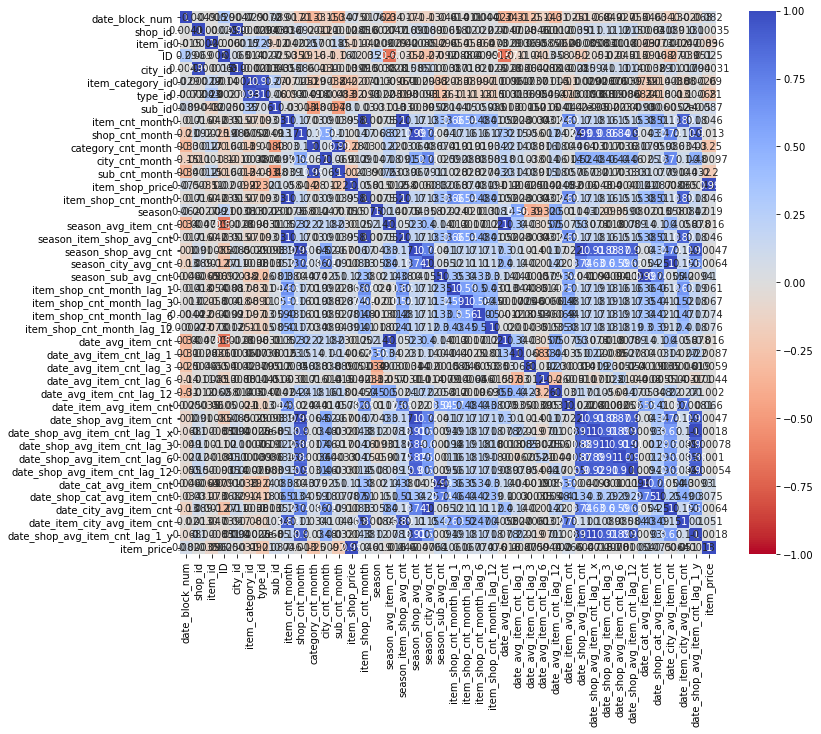

In [122]:
plt.figure(figsize = (12,10))
sns.heatmap(matrix5.corr(), annot = True, vmin = -1, vmax = 1, cmap  = 'coolwarm_r')
plt.show()

In [147]:
matrix5.isna().sum()

date_block_num                          0
shop_id                                 0
item_id                                 0
ID                                      0
city_id                                 0
item_category_id                        0
type_id                                 0
sub_id                                  0
item_cnt_month                          0
shop_cnt_month                          0
category_cnt_month                      0
city_cnt_month                          0
sub_cnt_month                           0
item_shop_price                   2625648
item_shop_cnt_month                     0
season                                  0
season_avg_item_cnt                     0
season_item_shop_avg_cnt                0
season_shop_avg_cnt                     0
season_city_avg_cnt                     0
season_sub_avg_cnt                      0
item_shop_cnt_month_lag_1         1395507
item_shop_cnt_month_lag_3         1808317
item_shop_cnt_month_lag_6         

In [139]:
k.drop('item_shop_price',axis=1).isna().sum()


KeyError: "['item_shop_price'] not found in axis"

In [114]:
k.index

Int64Index([      5,       6,       7,       8,       9,      10,      11,
                 12,      13,      14,
            ...
            6619789, 6619792, 6619799, 6619800, 6619802, 6619804, 6619805,
            6619810, 6619812, 6619814],
           dtype='int64', length=2625648)

,item_id,item_shop_price
32,34,142.363636


In [162]:
b

,item_shop_price
item_id,
0,58.000000
1,4490.000000
2,58.000000
3,79.000000
4,58.000000
...,...
22164,706.005850
22165,59.000000
22166,150.000000


In [147]:
b.items == i

False

In [ ]:
tc = time.time()
j = 0
l = matrix5.iloc[list(k),2]
for i in l:
    try:
        matrix5['item_shop_price',k[j]] = b[b.item_id == i].item_shop_price
    except:
        pass
print(time.time() - tc)
matrix5

In [165]:
matrix5.isna().sum()

date_block_num                          0
shop_id                                 0
item_id                                 0
ID                                      0
city_id                                 0
item_category_id                        0
type_id                                 0
sub_id                                  0
item_cnt_month                          0
shop_cnt_month                          0
category_cnt_month                      0
city_cnt_month                          0
sub_cnt_month                           0
item_shop_price                   2625648
item_shop_cnt_month                     0
season                                  0
season_avg_item_cnt                     0
season_item_shop_avg_cnt                0
season_shop_avg_cnt                     0
season_city_avg_cnt                     0
season_sub_avg_cnt                      0
item_shop_cnt_month_lag_1         1395507
item_shop_cnt_month_lag_3         1808317
item_shop_cnt_month_lag_6         

In [ ]:
matrix4.isnull().sum()

- month(월) 컬럼 추가

In [ ]:
matrix4['month'] = matrix4['date_block_num'] % 12

In [ ]:
matrix4

--------------------------------------------------------------------------------------

In [ ]:
#matrix4.to_pickle('data2.pkl')

In [ ]:
#matrix4.to_csv('data1.csv')

In [ ]:
matrix4

In [ ]:
col_list =[]
for i in matrix4.columns:
    if ('id' in i) | ('ID' in i):
        pass
    else:
        col_list.append(i)
col_list
k = matrix4.copy()
for i in col_list:
    k.loc[:,i] = StandardScaler().fit_transform(np.array(k.loc[:,i]).reshape(-1,1))

In [4]:
data1 = pd.read_pickle('data1.pkl')
data1

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,item_cnt_month,dec_0,dec_1,...,date_item_avg_item_cnt,date_shop_avg_item_cnt,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt
4478844,12,2,27,0,0,19,5,0.0,1,0,...,0.021744,0.118591,0.156494,0.099182,0.096130,0.141724,0.759766,0.793945,0.118591,0.0
4478845,12,2,30,0,0,40,11,0.0,1,0,...,1.260742,0.118591,0.156494,0.099182,0.096130,0.000000,0.264160,0.041809,0.118591,0.0
4478846,12,2,31,0,0,37,11,0.0,1,0,...,0.347900,0.118591,0.156494,0.099182,0.096130,0.000000,0.194824,0.052246,0.118591,0.0
4478847,12,2,32,0,0,40,11,1.0,1,0,...,1.826172,0.118591,0.156494,0.099182,0.096130,0.141724,0.264160,0.041809,0.118591,1.0
4478848,12,2,33,0,0,37,11,1.0,1,0,...,0.913086,0.118591,0.156494,0.099182,0.096130,0.141724,0.194824,0.052246,0.118591,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11312855,34,45,18454,214195,20,55,13,0.0,1,0,...,0.000000,0.000000,0.129761,0.139282,0.144287,0.000000,0.000000,0.000000,0.000000,0.0
11312856,34,45,16188,214196,20,64,14,0.0,1,0,...,0.000000,0.000000,0.129761,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
11312857,34,45,15757,214197,20,55,13,0.0,1,0,...,0.000000,0.000000,0.129761,0.139282,0.144287,0.197876,0.000000,0.000000,0.000000,0.0
11312858,34,45,19648,214198,20,40,11,0.0,1,0,...,0.000000,0.000000,0.129761,0.139282,0.144287,0.000000,0.000000,0.000000,0.000000,0.0


In [3]:
data1.columns

Index(['date_block_num', 'shop_id', 'item_id', 'ID', 'city_id',
       'item_category_id', 'type_id', 'item_cnt_month', 'dec_0', 'dec_1',
       'dec', 'dec_mean', 'shop_cnt_month', 'category_cnt_month',
       'city_cnt_month', 'type_cnt_month', 'item_shop_price',
       'item_shop_cnt_month', 'season_mean', 'season_0', 'season_1',
       'season_2', 'season_3', 'season', 'season_avg_item_cnt',
       'season_item_shop_avg_cnt', 'season_shop_avg_cnt',
       'season_city_avg_cnt', 'season_type_avg_cnt', 'dec_item_avg_cnt',
       'shop_close_0', 'shop_close_1', 'shop_close', 'shop_close_mean',
       'item_shop_cnt_month_lag_1', 'item_shop_cnt_month_lag_3',
       'item_shop_cnt_month_lag_6', 'item_shop_cnt_month_lag_12',
       'date_avg_item_cnt', 'date_avg_item_cnt_lag_1',
       'date_avg_item_cnt_lag_3', 'date_avg_item_cnt_lag_6',
       'date_avg_item_cnt_lag_12', 'date_item_avg_item_cnt',
       'date_shop_avg_item_cnt', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_ite

In [5]:
# data_onehot : 'season_mean', 'season_0', 'season_1', 'season_2', 'season_3', 'season', 'dec', 'dec_mean', 'shop_close', 'shop_close_mean'
data_onehot = data1.drop(columns = ['season_mean', 'season_0', 'season_1', 'season_2', 'season_3', 
                                    'season', 'dec', 'dec_mean', 'shop_close', 'shop_close_mean',
                                   'shop_close_0', 'shop_close_1'])
data_onehot

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,item_cnt_month,dec_0,dec_1,...,date_item_avg_item_cnt,date_shop_avg_item_cnt,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt
4478844,12,2,27,0,0,19,5,0.0,1,0,...,0.021744,0.118591,0.156494,0.099182,0.096130,0.141724,0.759766,0.793945,0.118591,0.0
4478845,12,2,30,0,0,40,11,0.0,1,0,...,1.260742,0.118591,0.156494,0.099182,0.096130,0.000000,0.264160,0.041809,0.118591,0.0
4478846,12,2,31,0,0,37,11,0.0,1,0,...,0.347900,0.118591,0.156494,0.099182,0.096130,0.000000,0.194824,0.052246,0.118591,0.0
4478847,12,2,32,0,0,40,11,1.0,1,0,...,1.826172,0.118591,0.156494,0.099182,0.096130,0.141724,0.264160,0.041809,0.118591,1.0
4478848,12,2,33,0,0,37,11,1.0,1,0,...,0.913086,0.118591,0.156494,0.099182,0.096130,0.141724,0.194824,0.052246,0.118591,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11312855,34,45,18454,214195,20,55,13,0.0,1,0,...,0.000000,0.000000,0.129761,0.139282,0.144287,0.000000,0.000000,0.000000,0.000000,0.0
11312856,34,45,16188,214196,20,64,14,0.0,1,0,...,0.000000,0.000000,0.129761,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
11312857,34,45,15757,214197,20,55,13,0.0,1,0,...,0.000000,0.000000,0.129761,0.139282,0.144287,0.197876,0.000000,0.000000,0.000000,0.0
11312858,34,45,19648,214198,20,40,11,0.0,1,0,...,0.000000,0.000000,0.129761,0.139282,0.144287,0.000000,0.000000,0.000000,0.000000,0.0


In [6]:
data_onehot.columns

Index(['date_block_num', 'shop_id', 'item_id', 'ID', 'city_id',
       'item_category_id', 'type_id', 'item_cnt_month', 'dec_0', 'dec_1',
       'shop_cnt_month', 'category_cnt_month', 'city_cnt_month',
       'type_cnt_month', 'item_shop_price', 'item_shop_cnt_month',
       'season_avg_item_cnt', 'season_item_shop_avg_cnt',
       'season_shop_avg_cnt', 'season_city_avg_cnt', 'season_type_avg_cnt',
       'dec_item_avg_cnt', 'item_shop_cnt_month_lag_1',
       'item_shop_cnt_month_lag_3', 'item_shop_cnt_month_lag_6',
       'item_shop_cnt_month_lag_12', 'date_avg_item_cnt',
       'date_avg_item_cnt_lag_1', 'date_avg_item_cnt_lag_3',
       'date_avg_item_cnt_lag_6', 'date_avg_item_cnt_lag_12',
       'date_item_avg_item_cnt', 'date_shop_avg_item_cnt',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt', 'date_shop_cat_avg_item_cnt',
       'date_city_avg_item_cnt

In [31]:
data_onehot.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,item_cnt_month,dec_0,dec_1,...,date_item_avg_item_cnt,date_shop_avg_item_cnt,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt
4478844,12,2,27,0,0,19,5,-0.0,0.225251,-0.225251,...,-0.149292,-0.700684,-0.383789,-0.529297,-0.450439,-0.079834,0.286133,0.0,-0.92334,-0.0
4478845,12,2,30,0,0,40,11,-0.0,0.225251,-0.225251,...,0.505371,-0.700684,-0.383789,-0.529297,-0.450439,-0.652832,-0.025223,-0.0,-0.92334,-0.0
4478846,12,2,31,0,0,37,11,-0.0,0.225251,-0.225251,...,0.023026,-0.700684,-0.383789,-0.529297,-0.450439,-0.652832,-0.068726,-0.0,-0.92334,-0.0
4478847,12,2,32,0,0,40,11,0.0,0.225251,-0.225251,...,0.803711,-0.700684,-0.383789,-0.529297,-0.450439,-0.079834,-0.025223,-0.0,-0.92334,0.0
4478848,12,2,33,0,0,37,11,0.0,0.225251,-0.225251,...,0.321777,-0.700684,-0.383789,-0.529297,-0.450439,-0.079834,-0.068726,-0.0,-0.92334,0.0


In [9]:
train_x = data_onehot[data_onehot['date_block_num'] < 33].drop('item_cnt_month',axis = 1)
train_y = data_onehot[data_onehot['date_block_num'] < 33].item_cnt_month
test_x = data_onehot[data_onehot['date_block_num'] == 33].drop('item_cnt_month',axis = 1)
test_y = data_onehot[data_onehot['date_block_num'] == 33].item_cnt_month

In [25]:
train_x = data_onehot[data_onehot['date_block_num'] < 34].drop('item_cnt_month',axis = 1)
train_y = data_onehot[data_onehot['date_block_num'] < 34].item_cnt_month
test_x = data_onehot[data_onehot['date_block_num'] == 34].drop('item_cnt_month',axis = 1)
test_y = data_onehot[data_onehot['date_block_num'] == 34].item_cnt_month

In [21]:
train_x.shape

(6167532, 40)

In [19]:
train_y.shape

(6167532,)

In [32]:
data_onehot[data_onehot['date_block_num'] == 34]

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,item_cnt_month,dec_0,dec_1,...,date_item_avg_item_cnt,date_shop_avg_item_cnt,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt
10884460,34,5,5037,0,3,19,5,-0.0,0.225251,-0.225251,...,-0.160767,-1.148438,-0.244629,0.035797,-0.097168,0.271729,-0.19104,-0.0,-1.512695,-0.0
10884461,34,5,5320,1,3,55,13,-0.0,0.225251,-0.225251,...,-0.160767,-1.148438,-0.952637,-0.891602,-0.805664,-0.652832,-0.19104,-0.0,-1.512695,-0.0
10884462,34,5,5233,2,3,19,5,-0.0,0.225251,-0.225251,...,-0.160767,-1.148438,-0.244629,0.035797,-0.097168,-0.652832,-0.19104,-0.0,-1.512695,-0.0
10884463,34,5,5232,3,3,23,5,-0.0,0.225251,-0.225251,...,-0.160767,-1.148438,-0.244629,0.035797,-0.805664,-0.652832,-0.19104,-0.0,-1.512695,-0.0
10884464,34,5,5268,4,3,20,5,-0.0,0.225251,-0.225251,...,-0.160767,-1.148438,-0.952637,-0.891602,-0.805664,-0.652832,-0.19104,-0.0,-1.512695,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11312855,34,45,18454,214195,20,55,13,-0.0,0.225251,-0.225251,...,-0.160767,-1.148438,-0.481201,-0.382812,-0.272705,-0.652832,-0.19104,-0.0,-1.512695,-0.0
11312856,34,45,16188,214196,20,64,14,-0.0,0.225251,-0.225251,...,-0.160767,-1.148438,-0.481201,-0.891602,-0.805664,-0.652832,-0.19104,-0.0,-1.512695,-0.0
11312857,34,45,15757,214197,20,55,13,-0.0,0.225251,-0.225251,...,-0.160767,-1.148438,-0.481201,-0.382812,-0.272705,0.147095,-0.19104,-0.0,-1.512695,-0.0
11312858,34,45,19648,214198,20,40,11,-0.0,0.225251,-0.225251,...,-0.160767,-1.148438,-0.481201,-0.382812,-0.272705,-0.652832,-0.19104,-0.0,-1.512695,-0.0


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [26]:
model = LinearRegression()
model.fit(train_x, train_y)

LinearRegression()

In [27]:
y_pred = model.predict(test_x)

In [28]:
y_pred 

array([0., 0., 0., ..., 0., 0., 0.])

In [29]:
r2_score(test_y, y_pred)

1.0

In [49]:
from sklearn.model_selection import train_test_split

In [20]:
from sklearn.neural_network import MLPRegressor

In [50]:
model = MLPRegressor(max_iter=1000, alpha=0.01, 
                       early_stopping=True, verbose=0, n_iter_no_change=50,
                       hidden_layer_sizes=(100, 10), random_state=1)

In [52]:
model = MLPRegressor()

In [ ]:
model.fit(train_x, train_y)

C:\Users\khb16\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\khb16\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-53-848a288d389e>", line 1, in <module>
    model.fit(train_x, train_y)
  File "C:\Users\khb16\anaconda3\lib\site-packages\IPython\core\displayhook.py", line 262, in __call__
    format_dict, md_dict = self.compute_format_data(result)
  File "C:\Users\khb16\anaconda3\lib\site-packages\IPython\core\displayhook.py", line 151, in compute_format_data
    return self.shell.display_formatter.format(result)
  File "C:\Users\khb16\anaconda3\lib\site-packages\IPython\core\formatters.py", line 150, in format
    format_dict, md_dict = self.mimebundle_formatter(obj, include=include, exclude=exclude)
  File "C:\Users\khb16\anaconda3\lib\site-packages\decorator.py", line 231, in fun
    return caller(func, *(extras + args), **kw)
  File "C:\Users\khb16\anaconda3\lib\site-packages\IP

TypeError: object of type 'NoneType' has no len()

In [ ]:
model.score(test_x, test_y)

In [7]:
col_list =[]
for i in data1.columns:
    if ('id' in i) | ('ID' in i) | ('date_block_num' in i):
        pass
    else:
        col_list.append(i)
col_list
k = data1.copy()
for i in col_list:
    k.loc[:,i] = StandardScaler().fit_transform(np.array(k.loc[:,i]).reshape(-1,1))

C:\Users\khb16\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
C:\Users\khb16\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
C:\Users\khb16\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
C:\Users\khb16\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
C:\Users\khb16\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
C:\Users\khb16\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
C:\Users\khb16\anacond

In [7]:
col_list =[]
for i in data_onehot.columns:
    if ('id' in i) | ('ID' in i) | ('date_block_num' in i):
        pass
    else:
        col_list.append(i)
col_list
k = data_onehot.copy()
for i in col_list:
    k.loc[:,i] = StandardScaler().fit_transform(np.array(k.loc[:,i]).reshape(-1,1))

C:\Users\khb16\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
C:\Users\khb16\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
C:\Users\khb16\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
C:\Users\khb16\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
C:\Users\khb16\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
C:\Users\khb16\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
C:\Users\khb16\anacond

In [8]:
data_onehot = k.copy()

# 2. EDA

### 1) 월별 거래수

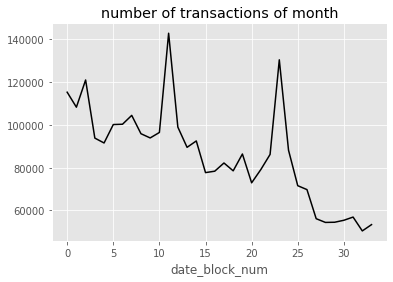

In [ ]:
#월별 거래수
sales.groupby('date_block_num').count()
sales.groupby('date_block_num')['date'].count()

transactions = sales.groupby('date_block_num')['date'].count()
transactions

plt.style.use('ggplot')
transactions.plot(title = 'number of transactions of month', color = 'black')
plt.show()

전체적으로 월별 거래수가 꾸준히 하락함  
엄청 높게 치솟는 두 개 점은 연말(13년 12월, 14년 12월)임

### 2) 월별 거래된 shops 수, 월별 거래된 items 수

In [ ]:
# 각 월 블록에서 매출 데이터에 거래가 있는 고유 상점 및 품목 수
shop_count = sales.groupby('date_block_num')['shop_id'].nunique()
item_count = sales.groupby('date_block_num')['item_id'].nunique()

sales.groupby('date_block_num').nunique()
#sales.groupby('date_block_num')['shop_id'].nunique() # 월별 고유 상점수
#sales.groupby('date_block_num')['item_id'].nunique()  # 월별 고유 아이템수

sales['item_id'].nunique() #item 21802개
items['item_id'].nunique() #item 22170개
#sales['shop_id'].nunique() #shop 60개
shops['shop_id'].nunique() #shop 60개

60

sales에 있는 item_id랑 items에 있는 item_id의 수가 다름

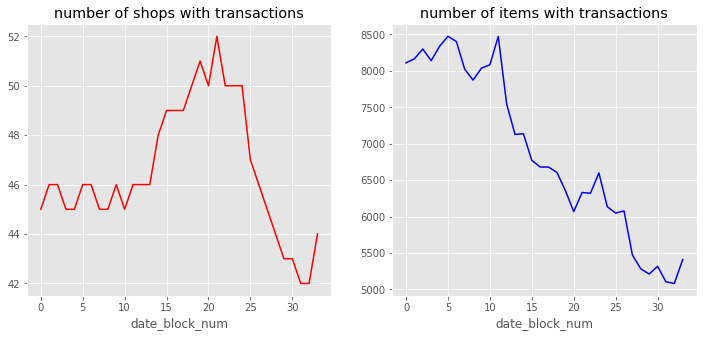

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
shop_count.plot(ax = ax[0], color = 'red')
item_count.plot(ax = ax[1], color = 'blue')
ax[0].set_title('number of shops with transactions') #거래가 있는 상점수
ax[1].set_title('number of items with transactions') #거래된 아이템수
plt.show()

연말을 제외하고는 월별 거래수와 월별 거래된 아이템수 모두 하락세
거래처들의 수는 2년차부터는 느는 듯 했으나 2말부터 훅훅 떨어짐  
그리고 거래처수가 60개로 나오는데 차트를 보면 매달 모든 가게에서 거래되는 게 아니고 물건도 많이 못미침

### 3) 상점별 하루 item 판매개수

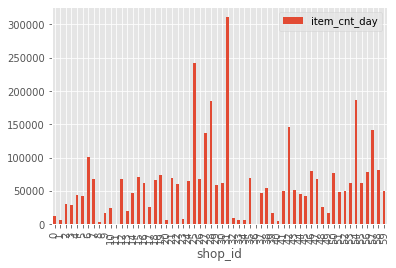

In [ ]:
shop_ns = sales[['shop_id','item_cnt_day']]
shop_ns.set_index(['shop_id'])
shop_ns = shop_ns.groupby(by=['shop_id']).sum()
shop_ns.plot(kind = 'bar')
plt.show()

### 4) 가격별 item 하루 판매개수

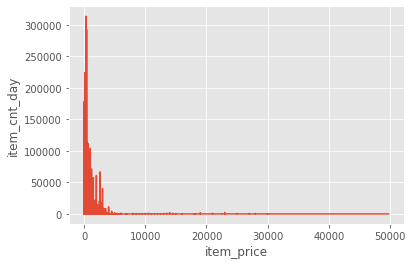

In [ ]:
price_ns = sales[['item_price','item_cnt_day']]
price_ns = price_ns.groupby(by=['item_price']).sum()
plt.plot(price_ns.index, price_ns.values)
plt.xlabel('item_price')
plt.ylabel('item_cnt_day')
plt.show()

### 5) 월별 총 판매금액

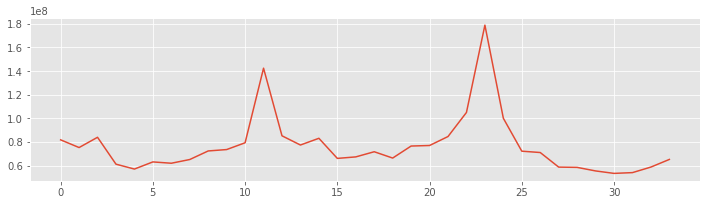

In [ ]:
# 월별 총 판매금액
time_ns = sales[['item_price','date_block_num']]
time_ns = time_ns.groupby(by=['date_block_num']).sum()
plt.figure(figsize=(12,3))
plt.plot(time_ns.index, time_ns.values)
plt.show()

### 6) 월별 총 판매개수

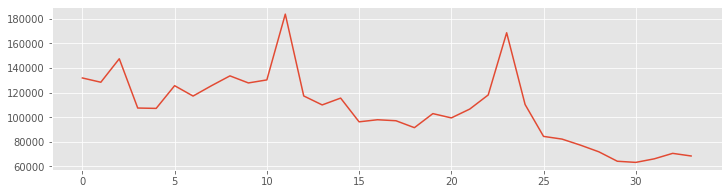

In [ ]:
# 월별 총 판매개수
group1 = sales.groupby(by=['date_block_num']).sum()
group1 = group1.reset_index()
plt.figure(figsize=(12,3))
plt.plot(group1.date_block_num,  group1.item_cnt_day)
plt.show()

### 7) 품목별 판매량

In [ ]:
sales1= pd.merge(sales, items, on=['item_id'], how='left')
sales1= pd.merge(sales1, item_categories, on=['item_category_id'], how='left')
sales1.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,item_category_id,type_id
0,2013-01-02,0,59,22154,999.00,1.0,999.00,37,11
1,2013-01-03,0,25,2552,899.00,1.0,899.00,58,13
2,2013-01-06,0,25,2554,1709.05,1.0,1709.05,58,13
3,2013-01-15,0,25,2555,1099.00,1.0,1099.00,56,13
4,2013-01-10,0,25,2564,349.00,1.0,349.00,59,13


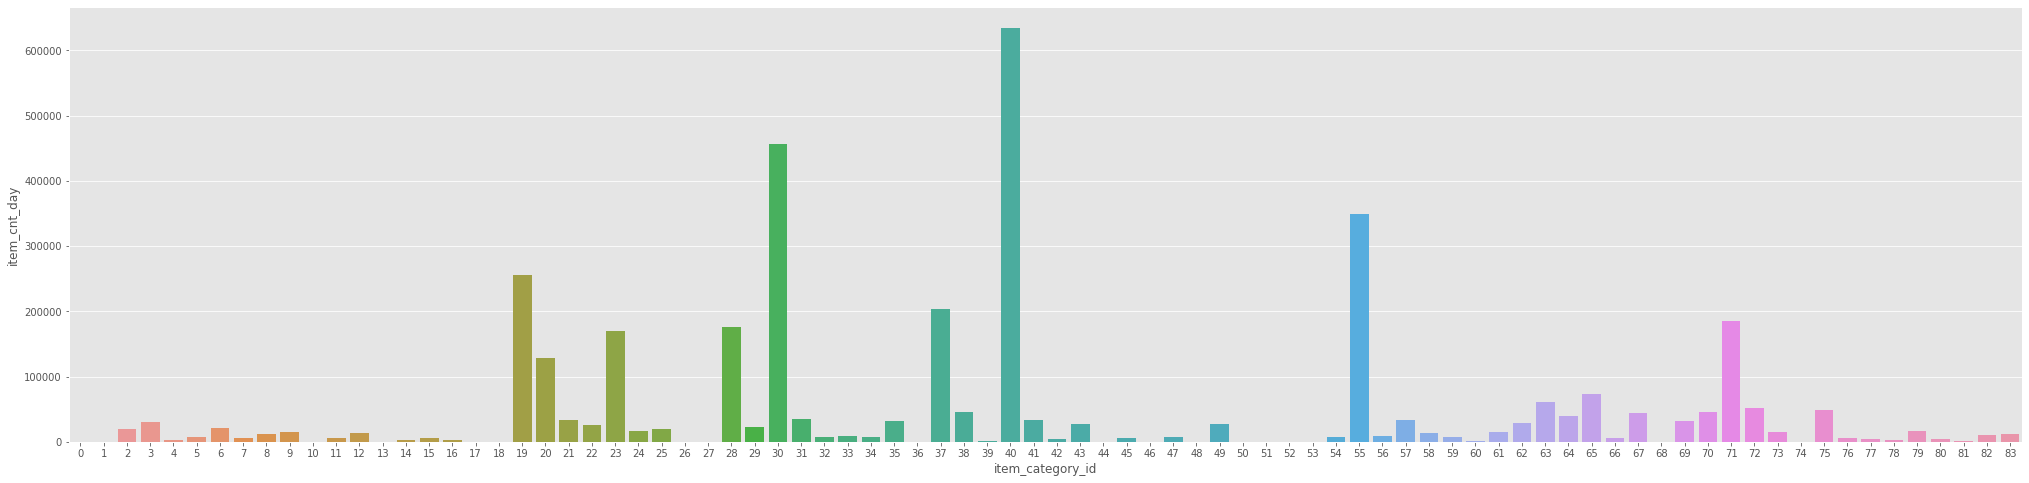

In [ ]:
# 품목별 판매량 
Category_sum=sales1.groupby(['item_category_id'], as_index=False)['item_cnt_day'].sum()
fig, axes = plt.subplots(1,1,figsize = (35,8))
sns.barplot(x="item_category_id",y="item_cnt_day", data=Category_sum)
plt.show()

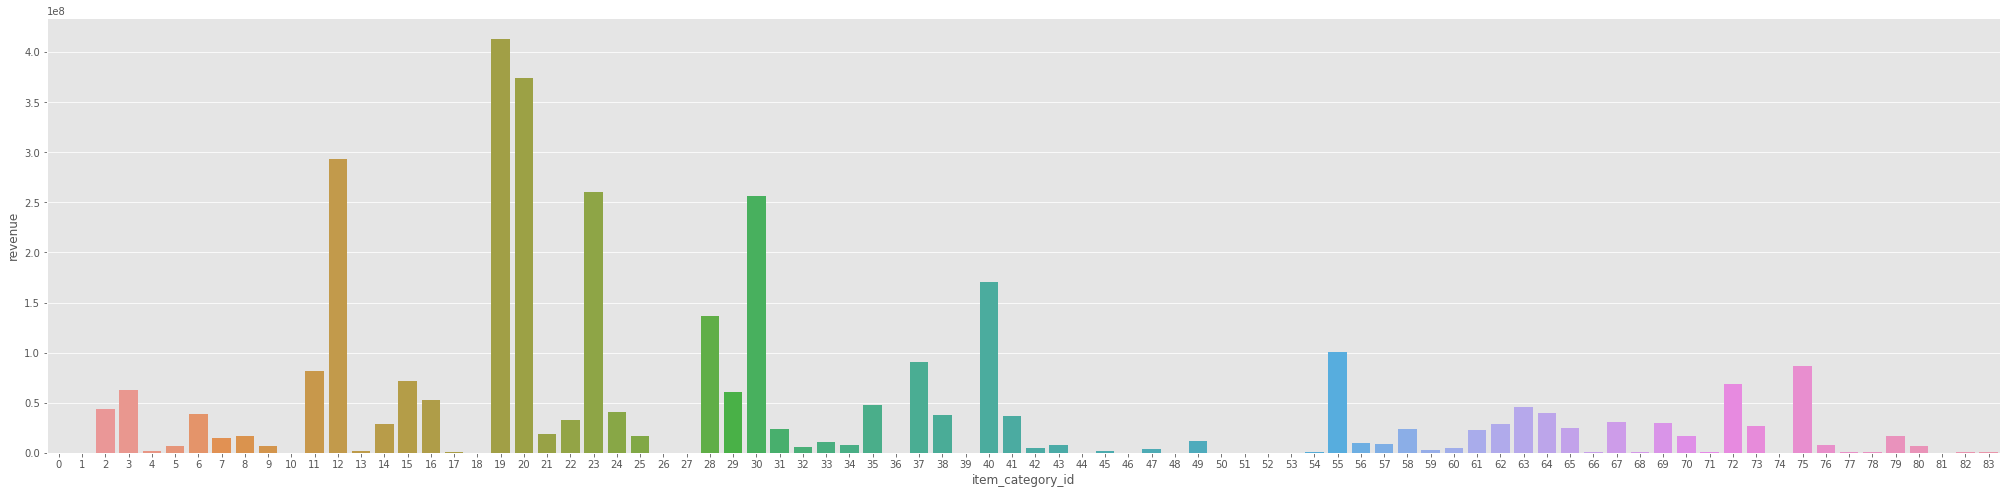

In [ ]:
# 카테고리별 판매금액
Category_sum=sales1.groupby(['item_category_id'], as_index=False)['revenue'].sum()
fig, axes = plt.subplots(1,1,figsize = (35,8))
sns.barplot(x="item_category_id",y="revenue", data=Category_sum)
plt.show()

In [ ]:
sales1['year'] = sales1['date'].dt.year
sales1['month'] = sales1['date'].dt.month
sales1.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,item_category_id,type_id,year,month
0,2013-01-02,0,59,22154,999.00,1.0,999.00,37,11,2013,1
1,2013-01-03,0,25,2552,899.00,1.0,899.00,58,13,2013,1
2,2013-01-06,0,25,2554,1709.05,1.0,1709.05,58,13,2013,1
3,2013-01-15,0,25,2555,1099.00,1.0,1099.00,56,13,2013,1
4,2013-01-10,0,25,2564,349.00,1.0,349.00,59,13,2013,1


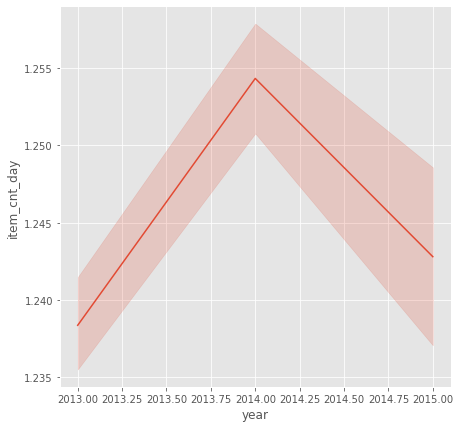

In [ ]:
#연도별 판매량  -> Year, Month 컬럼 만든 후 확인 가능합니다(이재호)
fig,axes = plt.subplots(1,1,figsize=(7,7))
sns.lineplot(x=sales1['year'],y=sales1['item_cnt_day'])
plt.show()

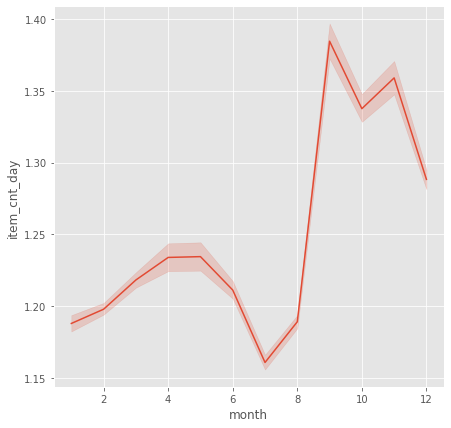

In [ ]:
# 월별 판매량
fig,axes = plt.subplots(1,1,figsize=(7,7))
sns.lineplot(x=sales1['month'],y=sales1['item_cnt_day'])
plt.show()

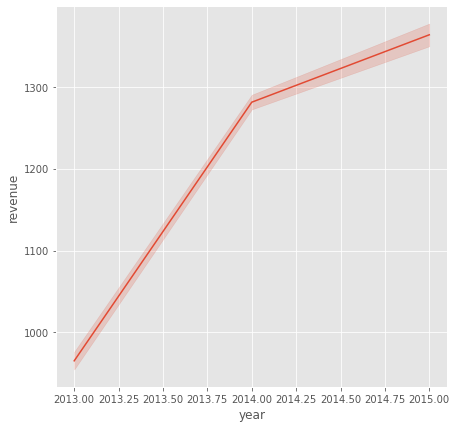

In [ ]:
# 연도별 판매총액 >> 14년 까진 꾸준하다가 14년부터 판매량 감소
fig,axes = plt.subplots(1,1,figsize=(7,7))
sns.lineplot(x=sales1['year'],y=sales1['revenue'])
plt.show()

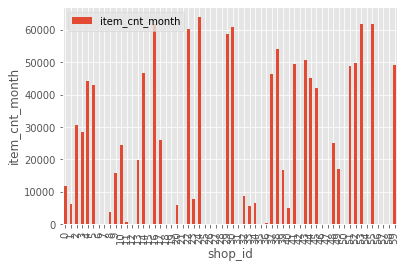

In [ ]:
# 상점별 월 item 판매개수 -> 월 별 item 판매개수 컬럼 만든 후 확인 가능합니다.(김홍비)
shop_ns = matrix[['shop_id','item_cnt_month']]
shop_ns.set_index(['shop_id'])
shop_ns = shop_ns.groupby(by=['shop_id']).sum()
shop_ns.plot(kind = 'bar')
plt.xlabel('shop_id')
plt.ylabel('item_cnt_month')
plt.show()

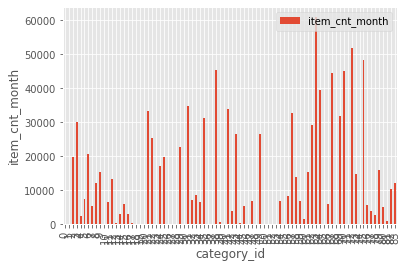

In [ ]:
# 카테고리별 판매개수
category_ns = matrix[['item_category_id','item_cnt_month']]
category_ns.set_index(['item_category_id'])
category_ns = category_ns.groupby(by=['item_category_id']).sum()
category_ns.plot(kind = 'bar')
plt.xlabel('category_id')
plt.ylabel('item_cnt_month')
plt.show()

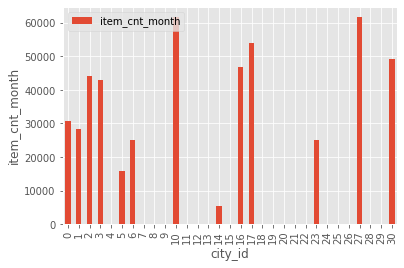

In [ ]:
# 도시별 판매개수
city_ns = matrix[['city_id','item_cnt_month']]
city_ns.set_index(['city_id'])
city_ns = city_ns.groupby(by=['city_id']).sum()
city_ns.plot(kind = 'bar')
plt.xlabel('city_id')
plt.ylabel('item_cnt_month')
plt.show()

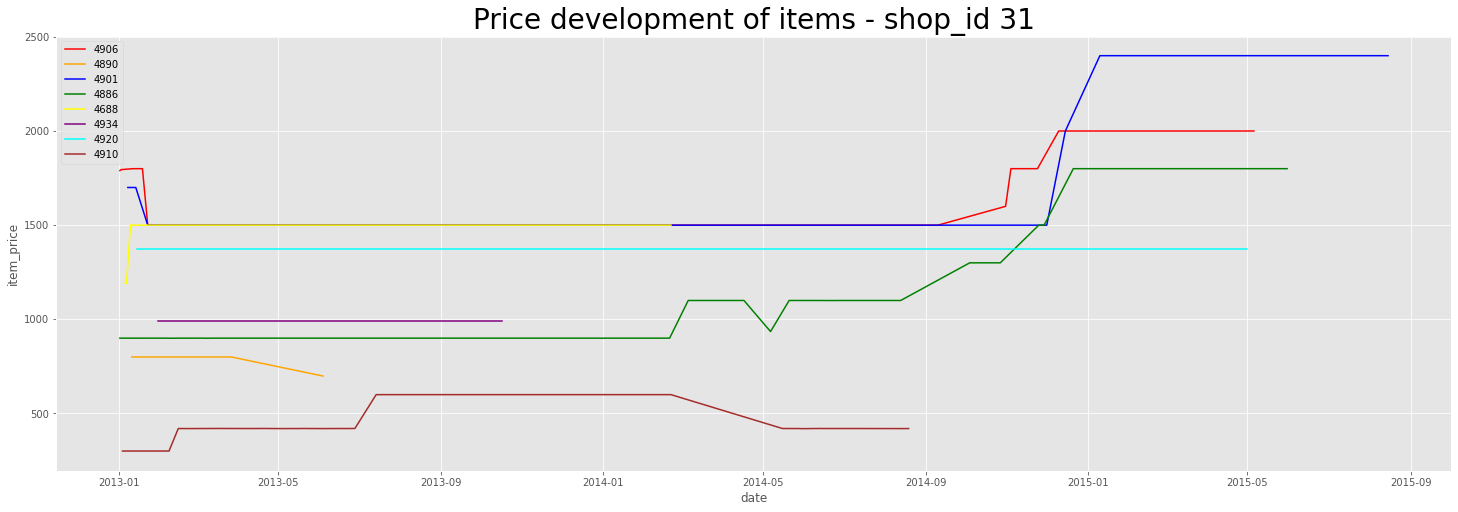

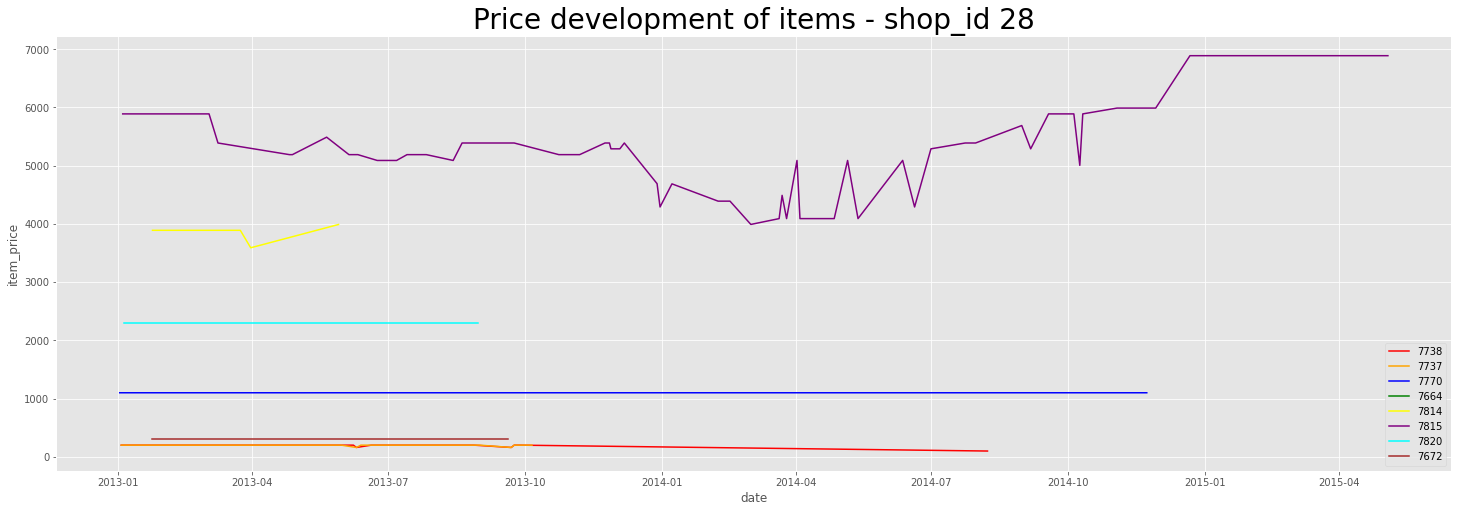

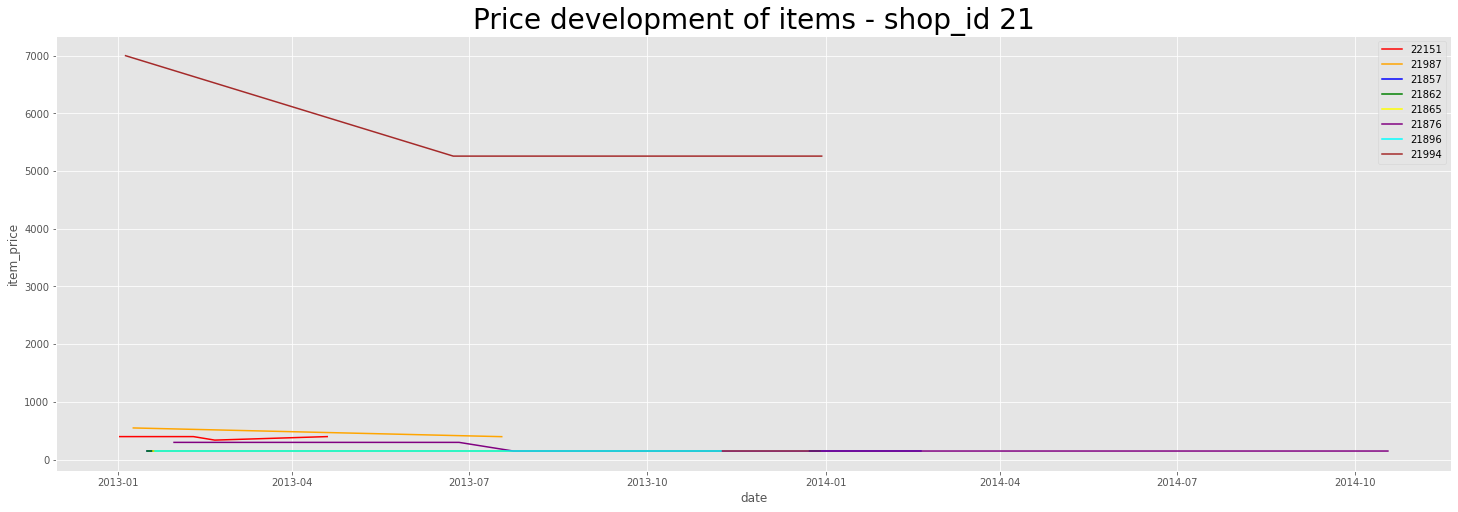

In [ ]:
# 동일한 item의 shop별 가격차이
sales_temp = sales[sales['shop_id'] == 31][['date','item_id','item_price']].reset_index(drop=True)
items_list = sales_temp['item_id'].unique()[0:8]

fig, axes = plt.subplots(1,1, figsize=(25,8))
colors = ['red','orange','blue','green','yellow','purple','cyan','brown']
for i, item in enumerate(items_list):
    dprice = sales_temp[sales_temp['item_id'] == item][['item_price','date']]
    
    sns.lineplot(x=dprice['date'], y=dprice['item_price'], ax=axes, color=colors[i], label=item)
    
axes.set_title('Price development of items - shop_id 31',fontsize="28")
axes.legend()
plt.show()


sales_temp = sales[sales['shop_id'] == 28][['date','item_id','item_price']].reset_index(drop=True)
items_list = sales_temp['item_id'].unique()[0:8]

fig, axes = plt.subplots(1,1, figsize=(25,8))
colors = ['red','orange','blue','green','yellow','purple','cyan','brown']
for i, item in enumerate(items_list):
    dprice = sales_temp[sales_temp['item_id'] == item][['item_price','date']]
    
    sns.lineplot(x=dprice['date'], y=dprice['item_price'], ax=axes, color=colors[i], label=item)
    
axes.set_title('Price development of items - shop_id 28',fontsize="28")
axes.legend()
plt.show()


sales_temp = sales[sales['shop_id'] == 21][['date','item_id','item_price']].reset_index(drop=True)
items_list = sales_temp['item_id'].unique()[0:8]

fig, axes = plt.subplots(1,1, figsize=(25,8))
colors = ['red','orange','blue','green','yellow','purple','cyan','brown']
for i, item in enumerate(items_list):
    dprice = sales_temp[sales_temp['item_id'] == item][['item_price','date']]
    
    sns.lineplot(x=dprice['date'], y=dprice['item_price'], ax=axes, color=colors[i], label=item)
    
axes.set_title('Price development of items - shop_id 21',fontsize="28")
axes.legend()
plt.show()

### [ 환불 적용 모듈 ]

In [ ]:
train_F = sales.copy()
k = train_F[train_F.item_cnt_day < 0]
qwe = 0
minimum = 0
timefunc = time.time()
for i in range(len(k)):
    try:
        if k.iloc[i,5] < minimum:
            minimum = k.iloc[i,5]
        a = (train_F[np.array(train_F.item_id == k.iloc[i,3]) & np.array(train_F.shop_id == k.iloc[i,2])])
        if a.date.min() < k.iloc[i,0]:
            h = a[a.date==a.date[a.date < k.iloc[i,0]].max()].index[0]
            qwe += 1
            train_F.loc[h,'item_cnt_day'] += k.iloc[i,5]
#            if qwe == 5:
#                break
        else:
            pass
    except:
        pass
train_F.drop(k.index,axis = 0,inplace = True)
print(len(k))
print('필요 없는 값:',(len(k) - qwe))
print('적용한 값의 수::',qwe)
print(minimum)
print(time.time() - timefunc)